In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io
import scipy.signal
from scipy.signal import butter, lfilter

## Load and Parse Data CSV

In [2]:
datadict = {}
path = "4222019sweep" #filepath to the data
for file in os.listdir(path):
    try:
        filename = file.split('_')[3].split('.csv')[0]
    except:
        continue
    datadict[filename] = pd.read_csv(path +'/'+ file)

print("There are {} load conditions".format(len(datadict.keys())))

There are 258 load conditions


In [3]:
try:
    for dataname in datadict.keys():
        datadict[dataname].drop("Unnamed: 0",axis =1,inplace = True)
except:
    pass

<IPython.core.display.Javascript object>


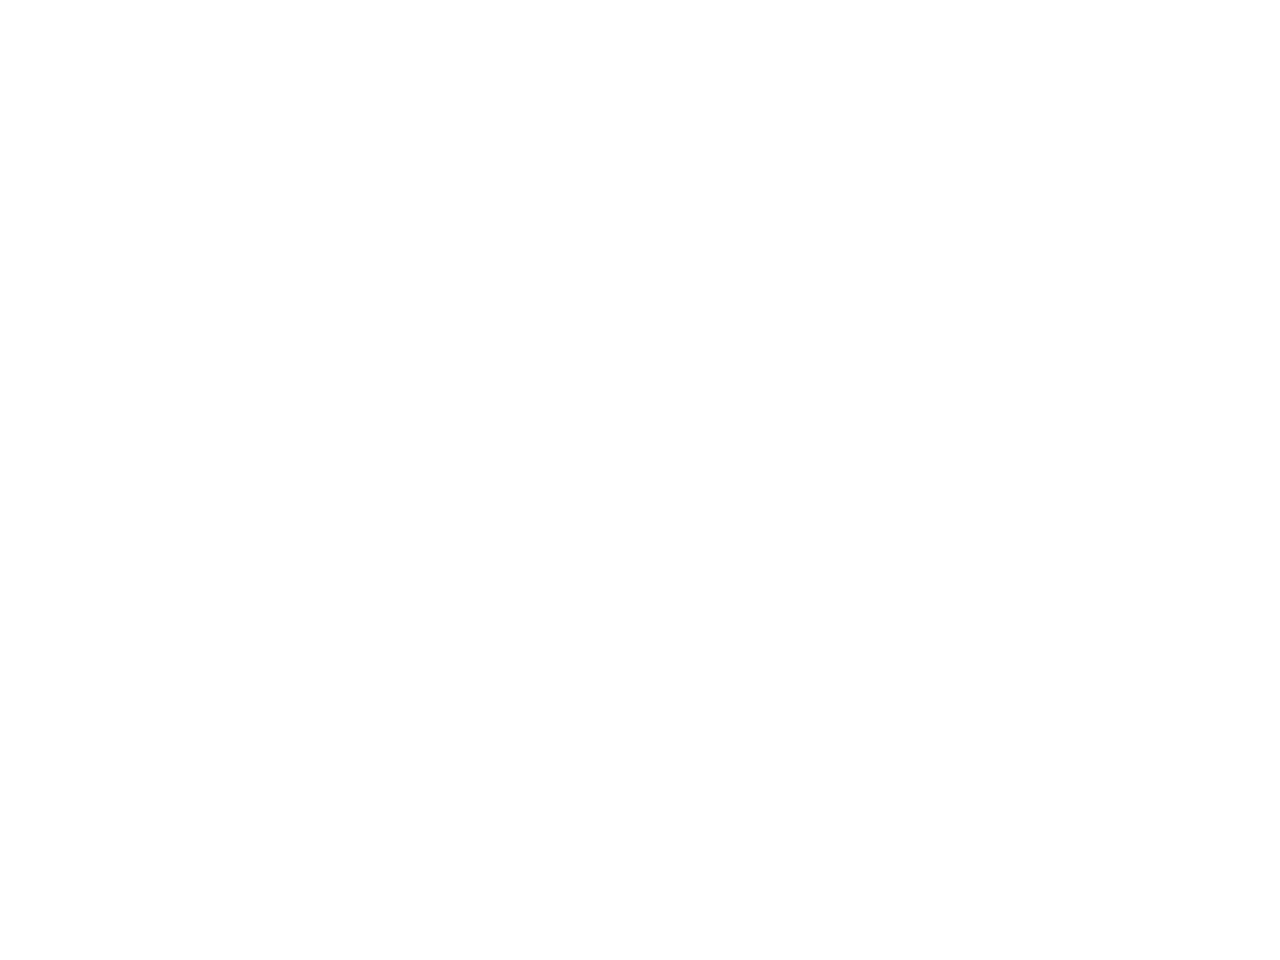

In [4]:
%matplotlib notebook
plt.ion()
plt.plot(datadict['short']['backscatter'],label = 'short')
plt.plot(datadict['open']['backscatter'],label = 'open')
plt.title('Open vs Short Backscatter')
plt.ioff()
plt.legend();

### Select a cutoff value and correct phase offset

Look at the short vs backscatter graph to select a nice cutoff to remove initial reflection 

In [5]:
off = len(datadict['open']['backscatter'])-1-np.argmax(scipy.signal.correlate(datadict['short']['backscatter'],datadict['open']['backscatter']))
print("The phase is offset by {}".format(off))

The phase is offset by 0


In [6]:
cutoff = 2000 #Look at graph above to chose
short = datadict['short']['backscatter'][cutoff:]
openn = datadict['open']['backscatter'][cutoff:]
#PHASE OFFSET CORRECTION
sadj = np.pad(short, (off,0), 'constant', constant_values=0)
oadj = np.pad(openn, (0,off), 'constant', constant_values=0)

***


## Analysis

### Maximum Modulation Analysis Method

<IPython.core.display.Javascript object>


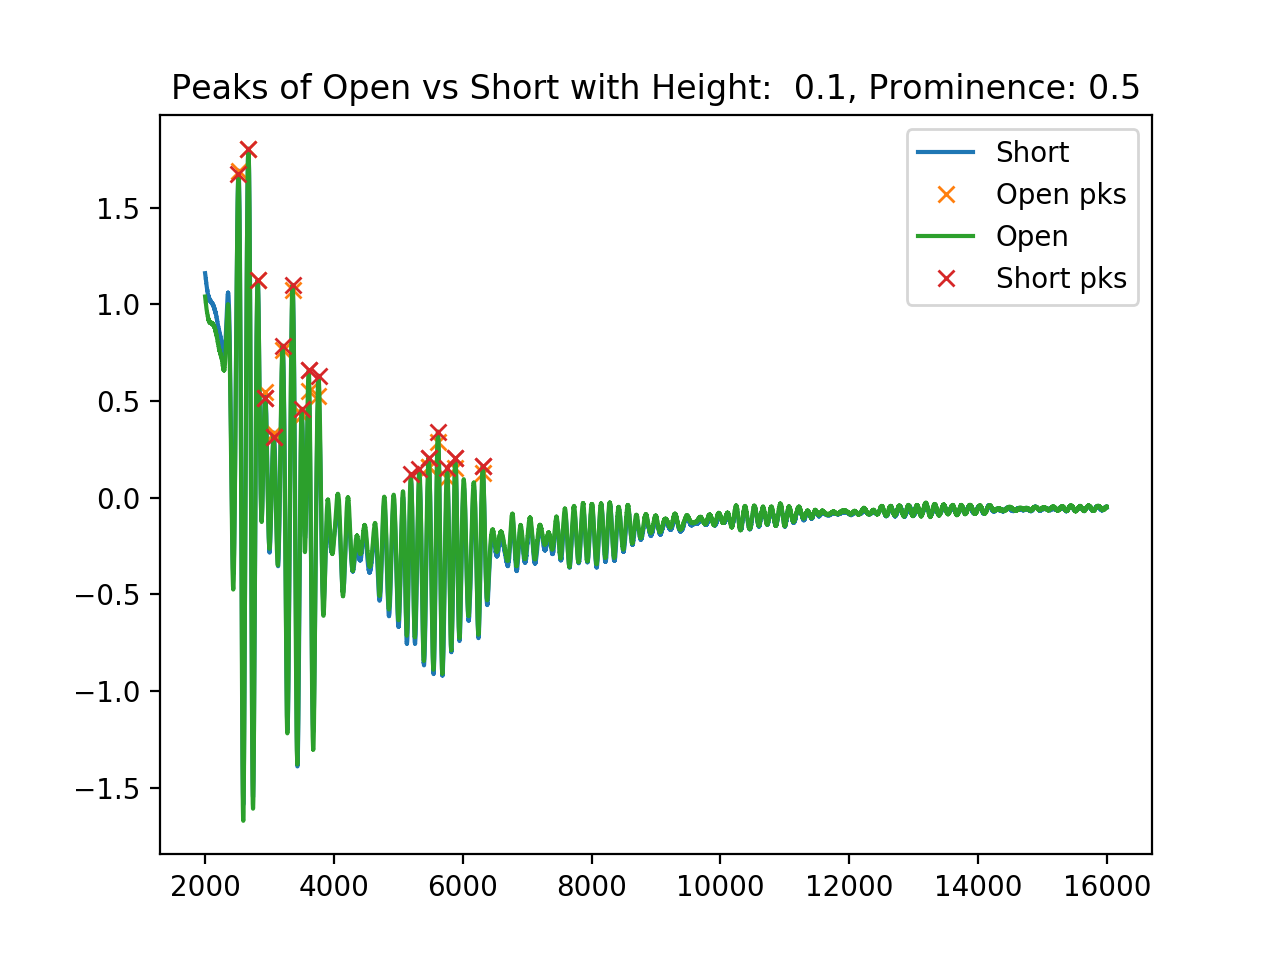

In [7]:
%matplotlib notebook
#Adjust the height and prominence to select more peaks as needed
height = .1
prominence = .5


speaks, _ = scipy.signal.find_peaks(short,height = height, prominence = prominence)
speaks = speaks + cutoff
plt.plot(short,label = 'Short')
plt.plot(speaks, short[speaks], "x", label = 'Open pks')

opeaks, _ = scipy.signal.find_peaks(openn,height = height, prominence = prominence)
opeaks = opeaks+cutoff
plt.plot(openn, label = 'Open')
plt.plot(opeaks, openn[opeaks], "x", label = 'Short pks')
plt.title('Peaks of Open vs Short with Height:  {}, Prominence: {}'.format(height,prominence))
plt.legend()

In [8]:
opks = []
spks = []
allpks = []
for x in speaks:
    for y in opeaks:
        if abs(x-y) < 10:
            spks.append(x)
            opks.append(y)
            allpks.append(int((x+y)/2))
            
print("Open Peaks:")
print(opks)
print("\n Short Peaks:")
print(spks)
print("\n All Peaks:")
print(allpks)

Open Peaks:
[2518, 2672, 2815, 2930, 2932, 3062, 3065, 3204, 3357, 3501, 3501, 3607, 3609, 3761, 5470, 5473, 5470, 5473, 5614, 5759, 5884, 5886, 6310, 6313]

 Short Peaks:
[2519, 2673, 2817, 2932, 2932, 3065, 3065, 3206, 3359, 3501, 3503, 3608, 3608, 3760, 5471, 5471, 5473, 5473, 5617, 5759, 5886, 5886, 6312, 6312]

 All Peaks:
[2518, 2672, 2816, 2931, 2932, 3063, 3065, 3205, 3358, 3501, 3502, 3607, 3608, 3760, 5470, 5472, 5471, 5473, 5615, 5759, 5885, 5886, 6311, 6312]


In [9]:
modulation = openn[opks].values - short[spks].values
idx = modulation.argmax()
diffo = opks[idx]
diffsh = spks[idx]
diffid = diffo
print("The peak with the maximum modulation is: {} with a modulation of {}".format(diffid, modulation[idx]))

The peak with the maximum modulation is: 3607 with a modulation of 0.10552765440000011


<IPython.core.display.Javascript object>


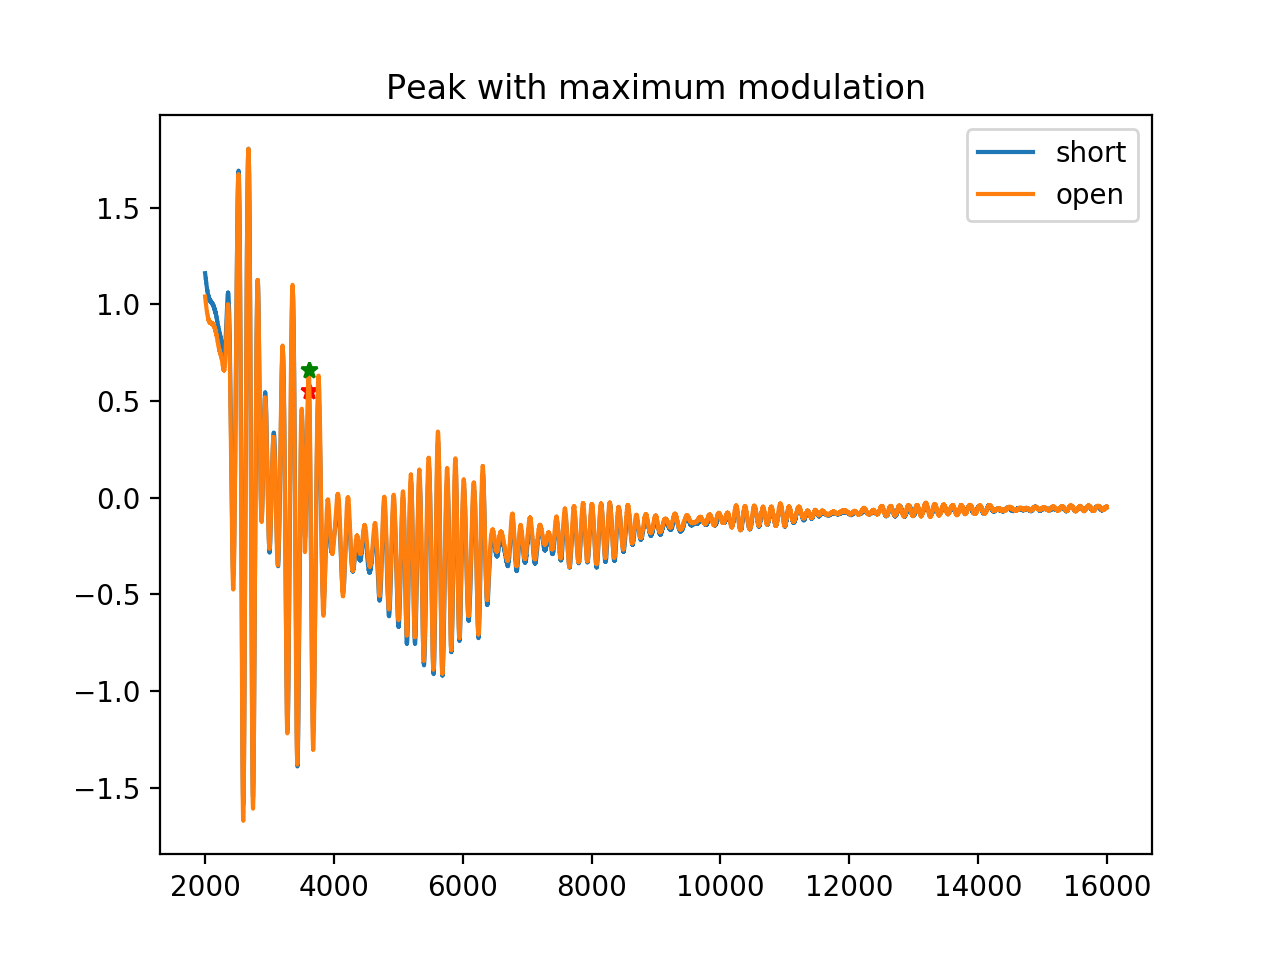

Text(0.5, 1.0, 'Peak with maximum modulation')

In [11]:
%matplotlib notebook
plt.plot(short,label = 'short')
plt.plot(diffsh,short[diffsh],'r*')

plt.plot(openn,label = 'open')
plt.plot(diffo,openn[diffo],'g*')
plt.legend()
plt.title("Peak with maximum modulation")

In [19]:
#Function to find peak in a particular range of values (ensure correct peak selection)
def findpeak(data,idx):
    idx = (int)(idx)
    data = data
    return (data[idx - 50: idx + 50]).idxmax()

In [20]:
#Get the integer value for the filenames
def getnum(name):
    if 'short' in name:
        return 0
    elif 'open' in name:
        return -1
    elif 'p' in name:
        name = name.replace('p','.')
    if 'k' in name:
        return float(name.split('k')[0])*1000
    elif 'M' in name:
        return float(name.split('M')[0])*1000000
    else:
        return float(name)
    

In [21]:
# function to find all the values at a particular peak returns a python dictionary 
# where keys are loads and values are peak values

def pktodict(diffidx, plot = True):
    retdict = {}
    %matplotlib inline
    for key in datadict.keys():
        testback = datadict[key]['backscatter']
        pk = findpeak(testback,diffidx)
        retdict[getnum(key)] = testback[pk]
        if plot:
            plt.figure()
            plt.plot(testback[cutoff:],label = key)
            plt.plot(pk,testback[pk],'r*')
            plt.legend()
            plt.suptitle("Peak at {}".format(diffidx))
    return retdict


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


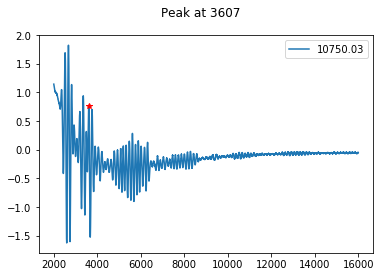

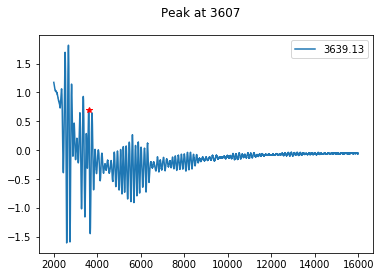

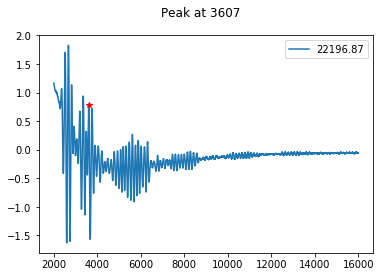

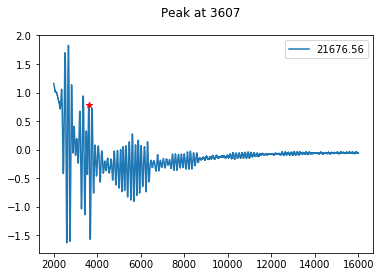

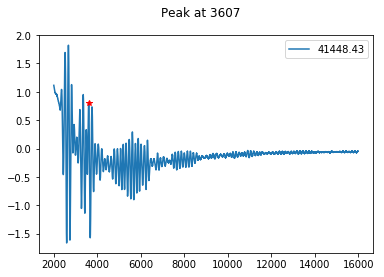

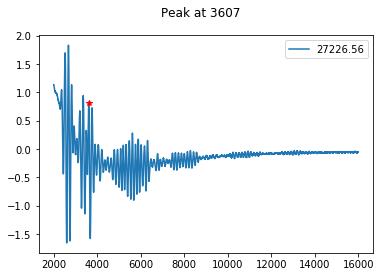

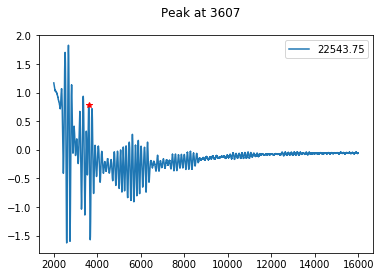

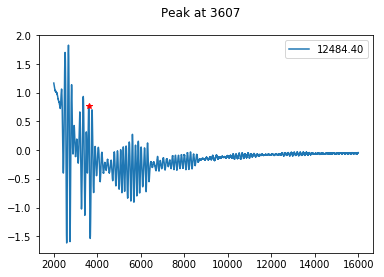

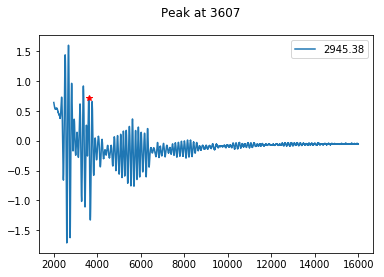

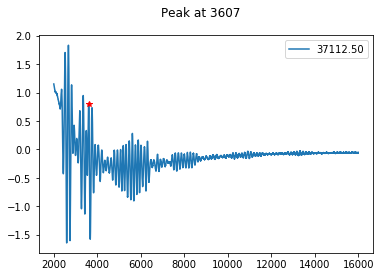

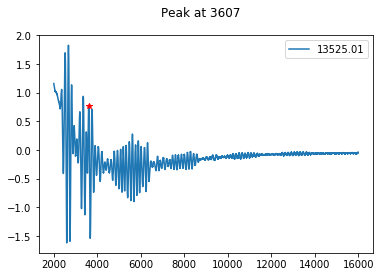

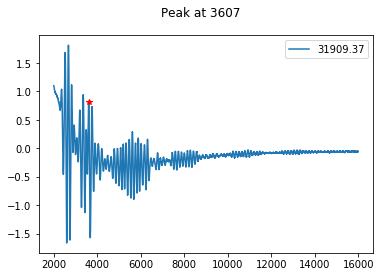

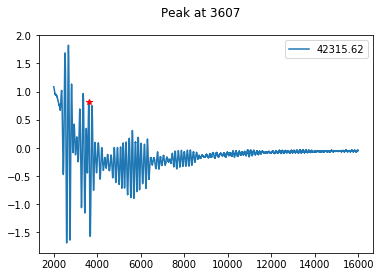

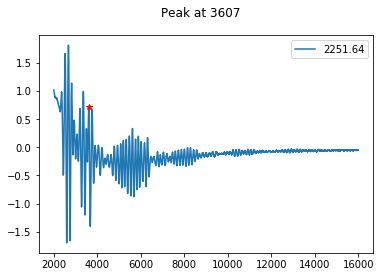

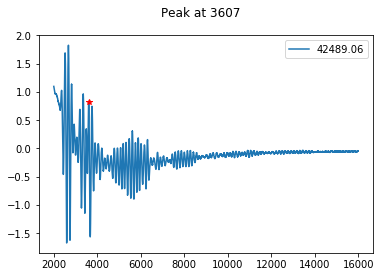

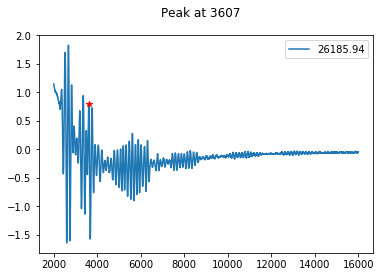

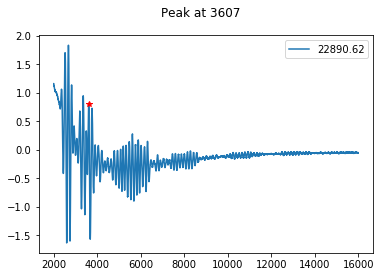

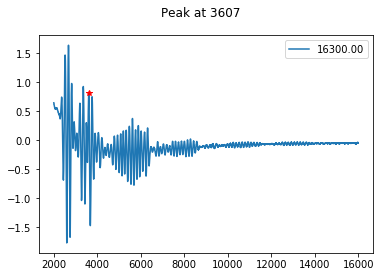

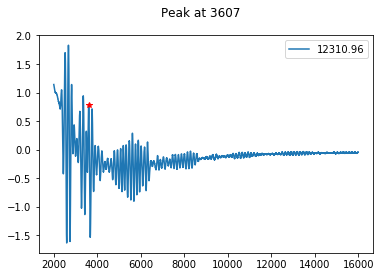

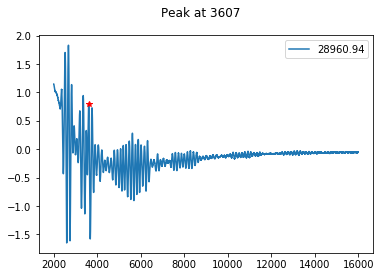

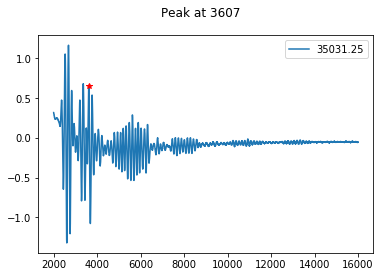

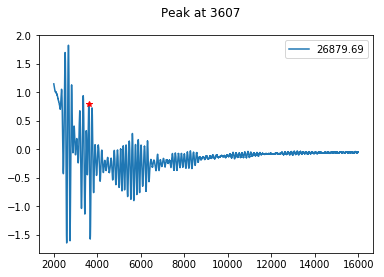

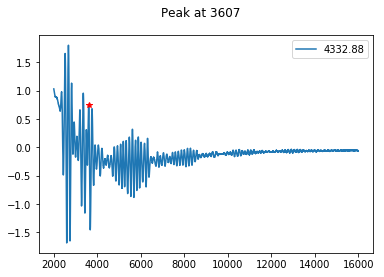

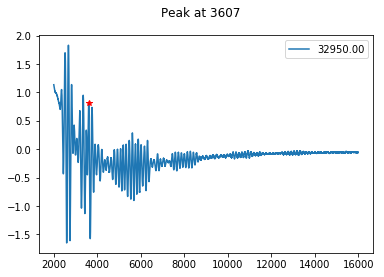

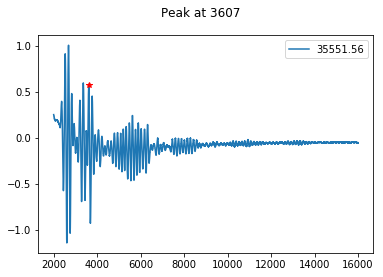

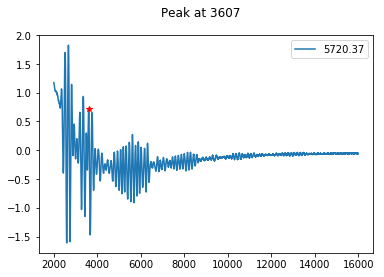

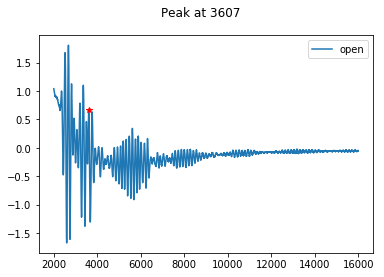

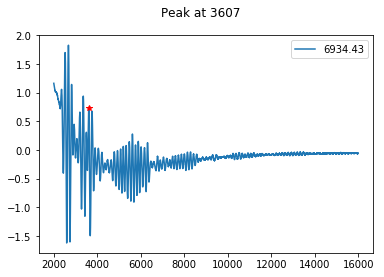

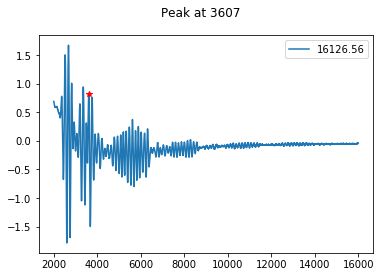

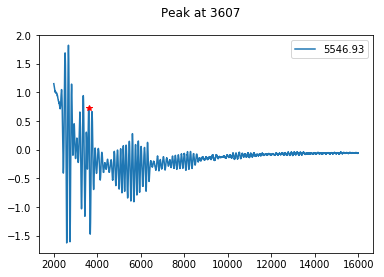

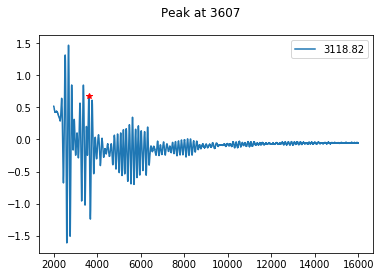

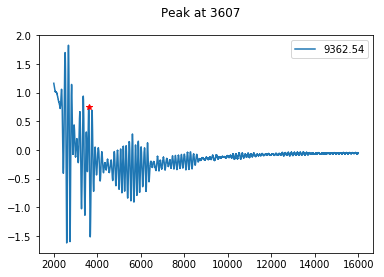

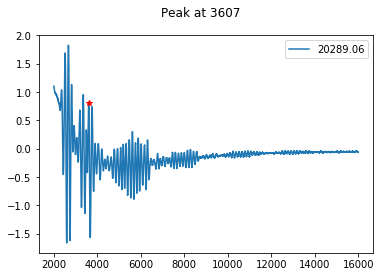

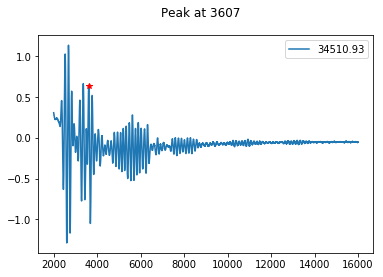

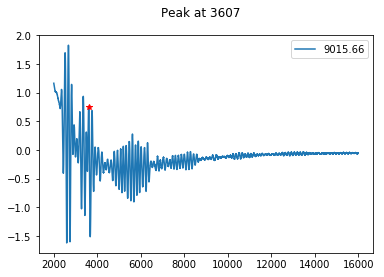

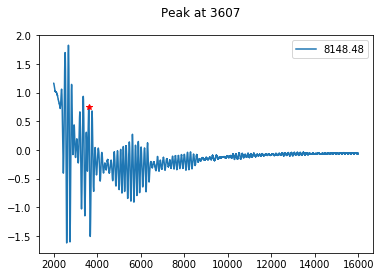

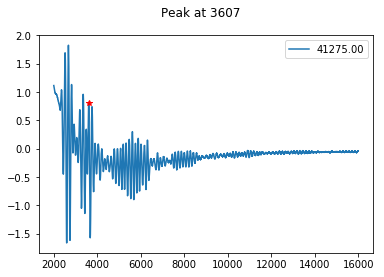

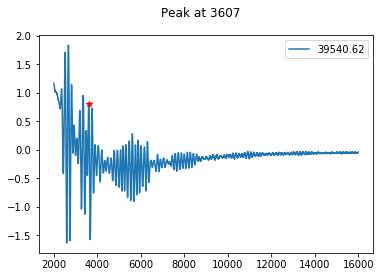

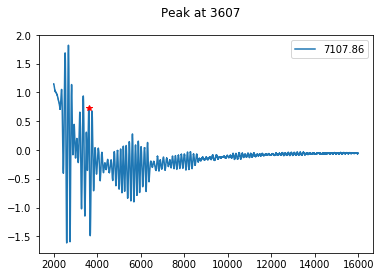

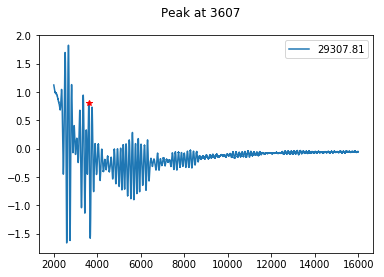

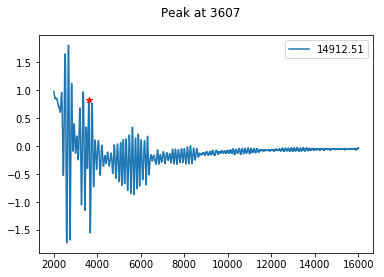

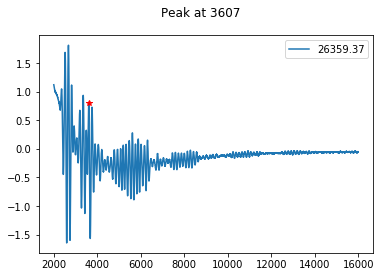

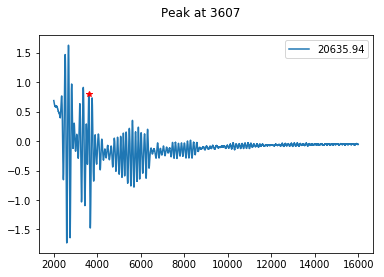

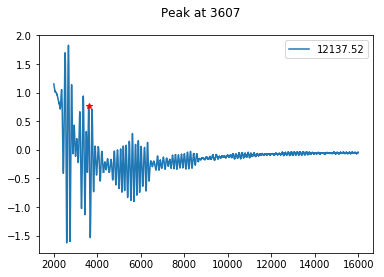

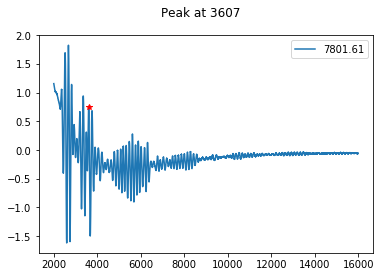

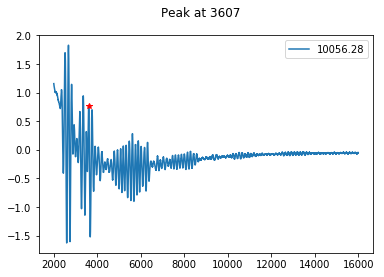

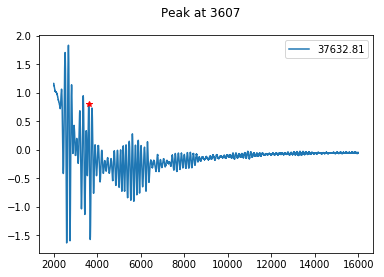

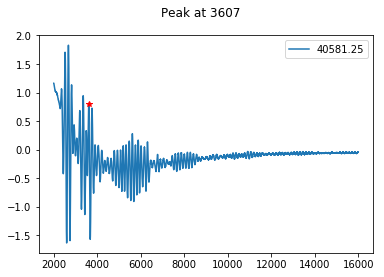

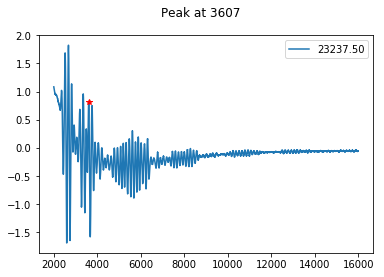

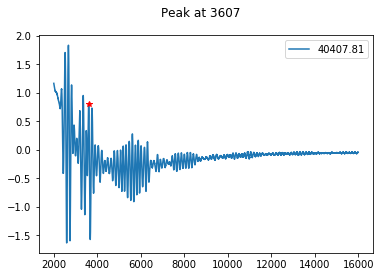

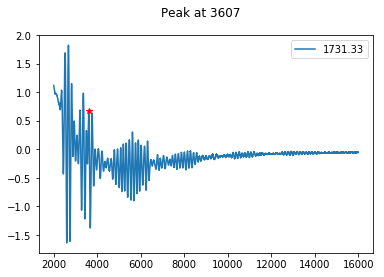

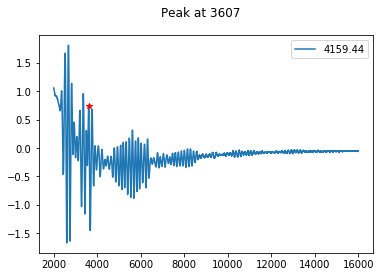

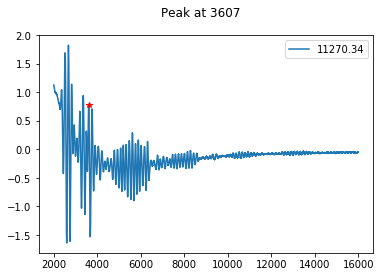

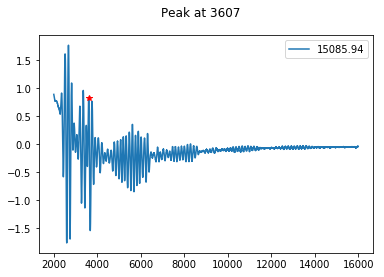

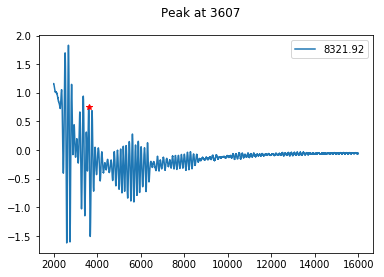

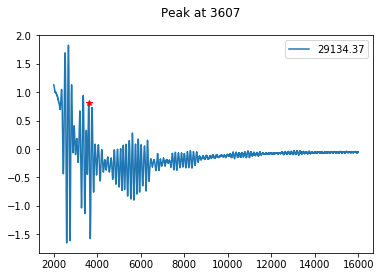

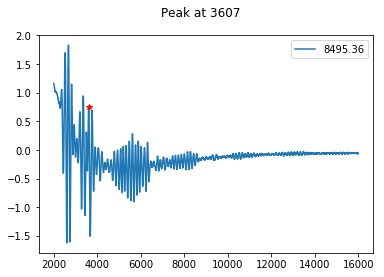

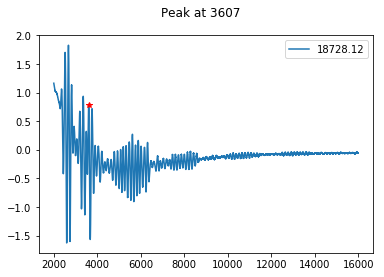

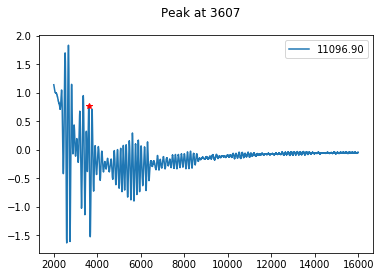

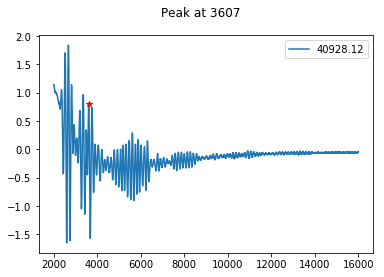

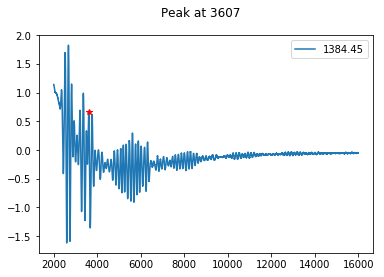

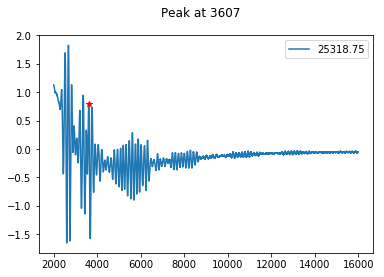

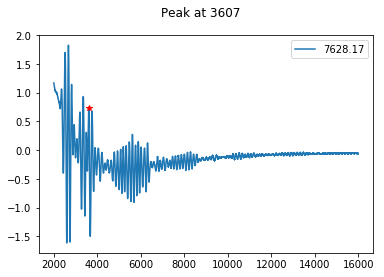

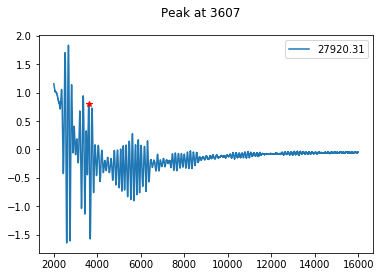

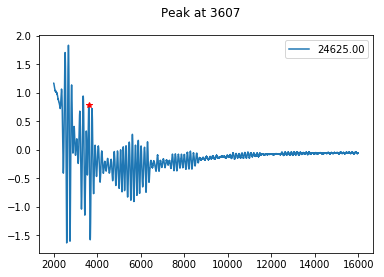

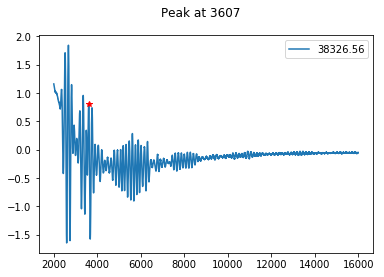

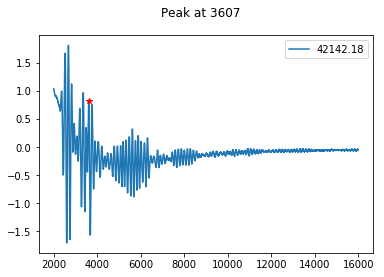

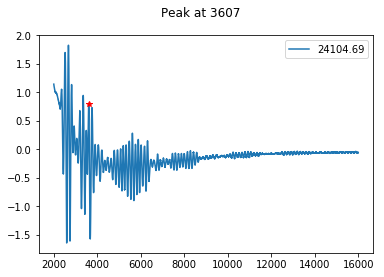

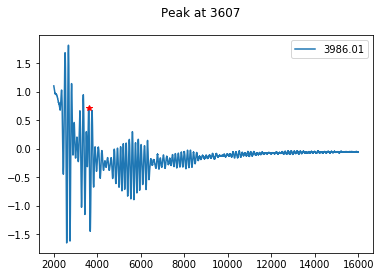

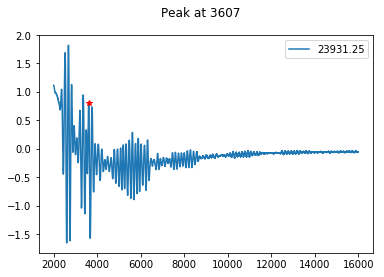

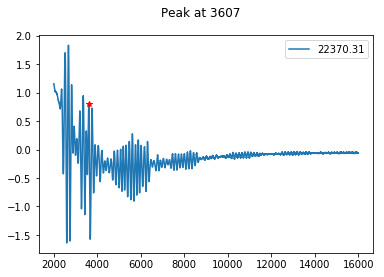

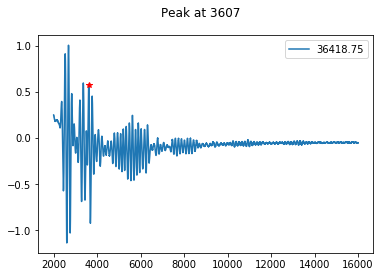

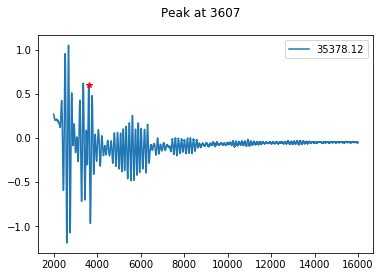

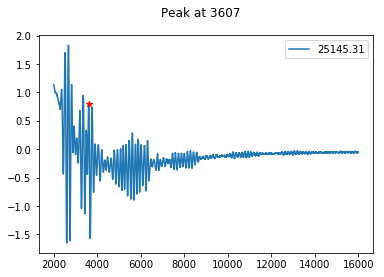

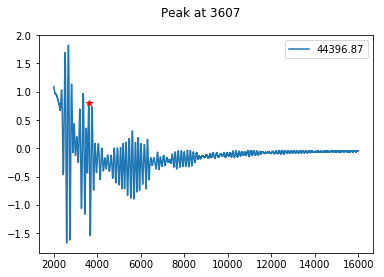

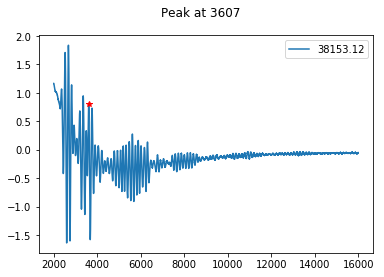

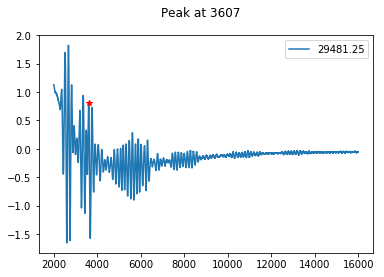

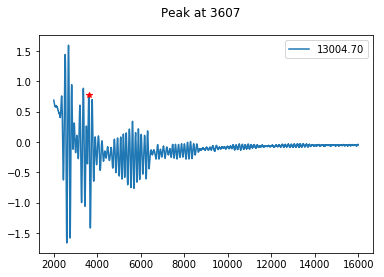

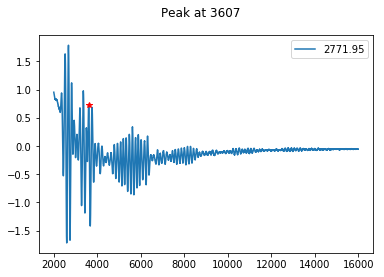

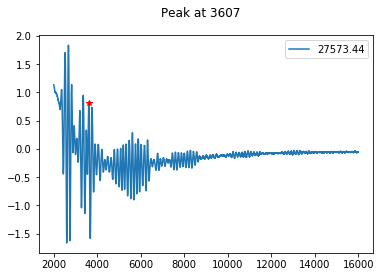

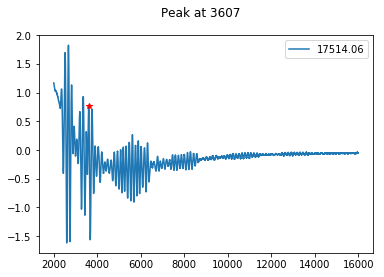

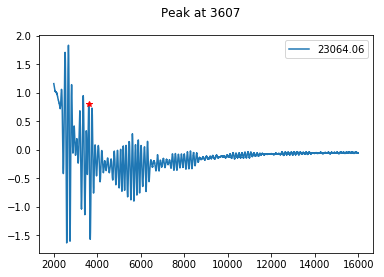

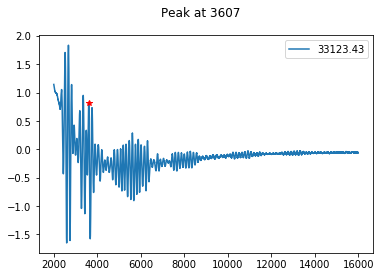

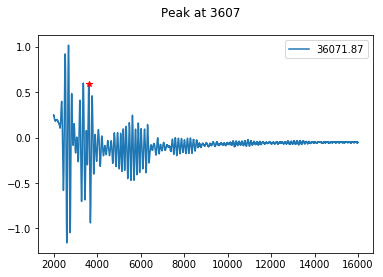

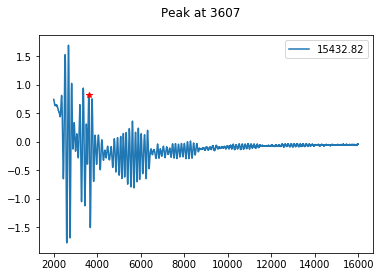

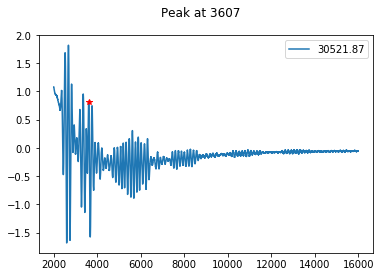

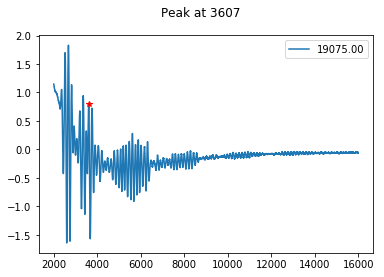

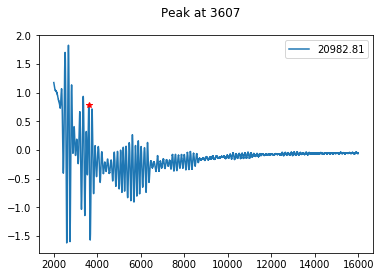

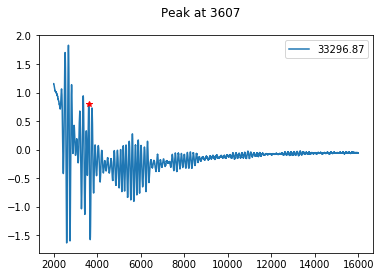

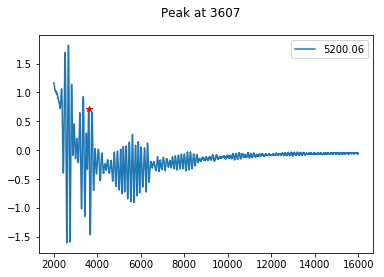

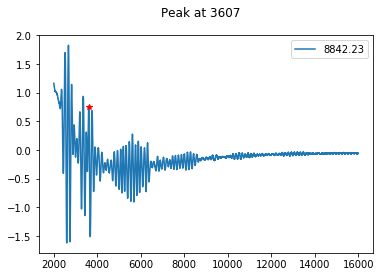

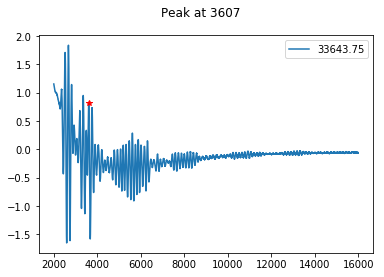

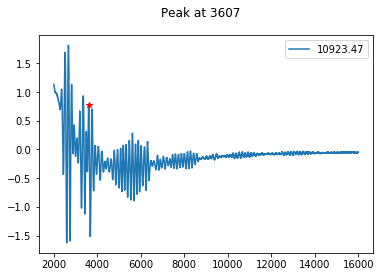

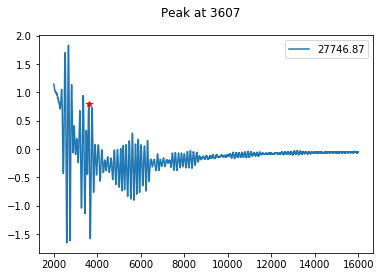

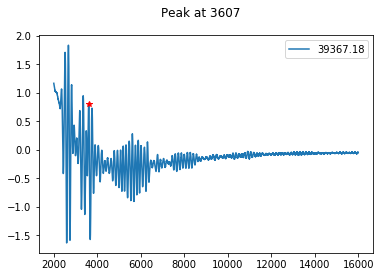

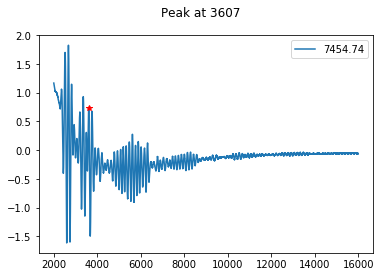

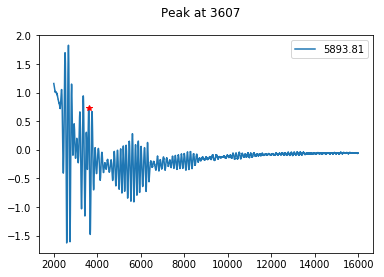

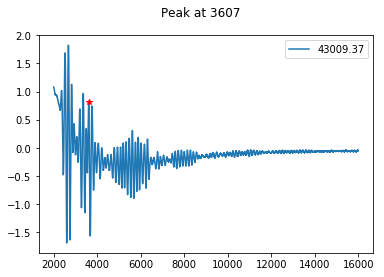

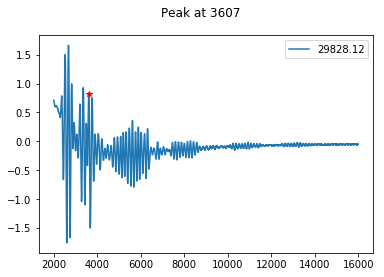

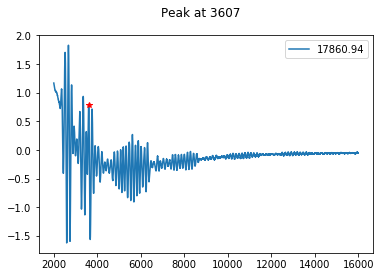

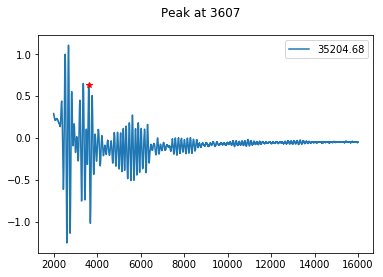

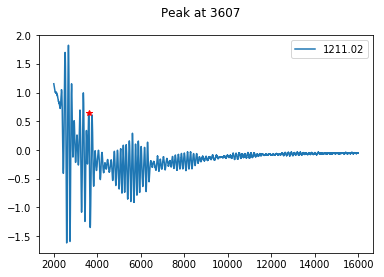

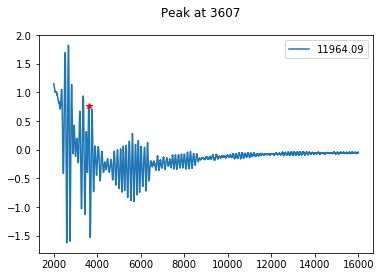

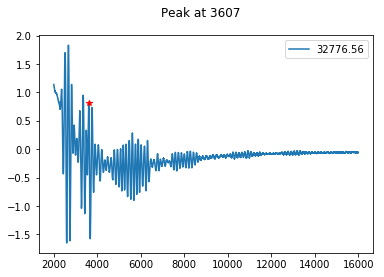

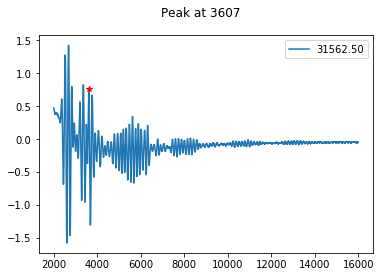

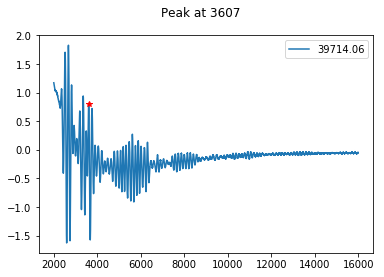

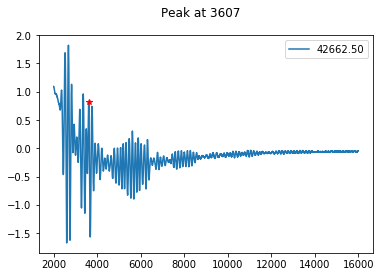

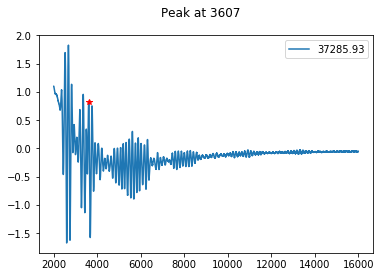

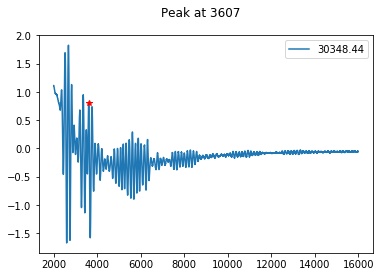

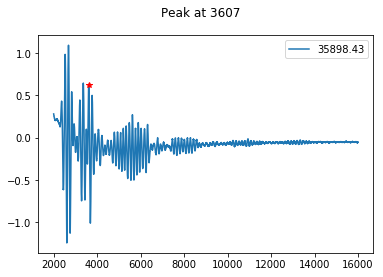

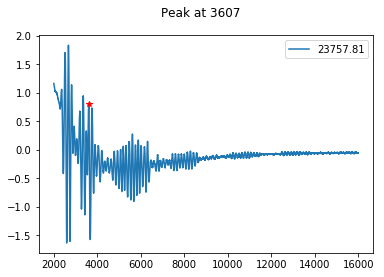

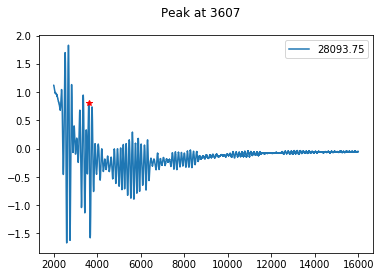

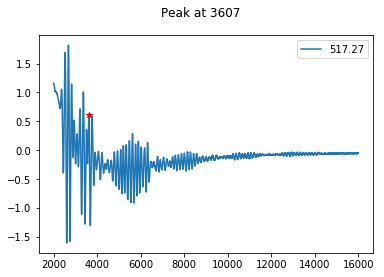

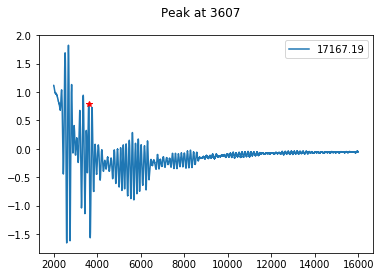

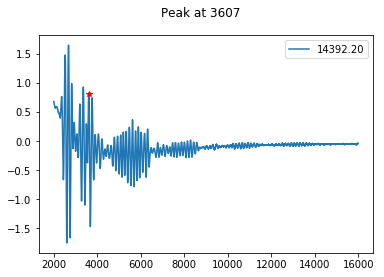

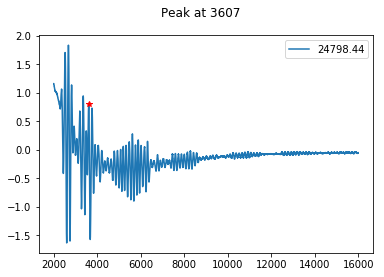

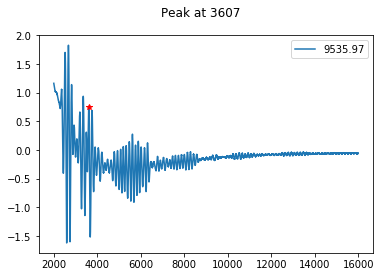

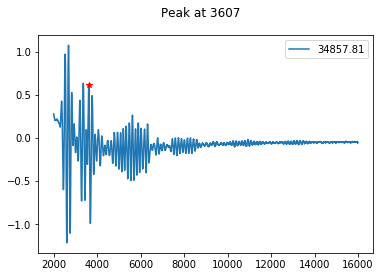

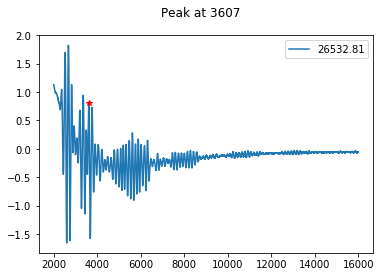

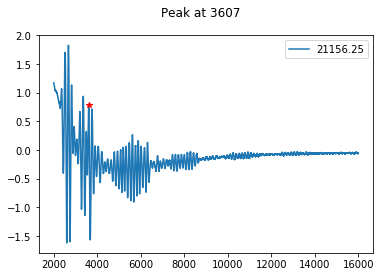

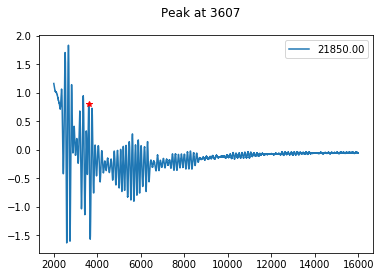

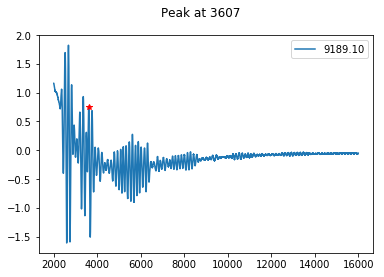

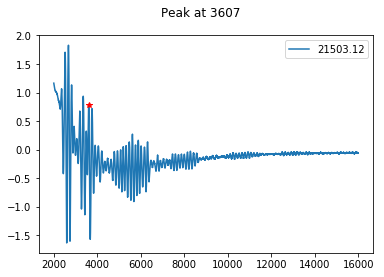

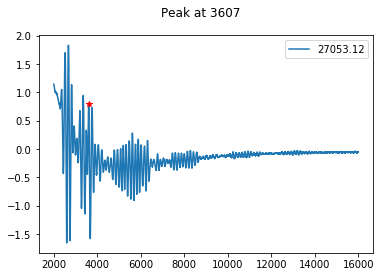

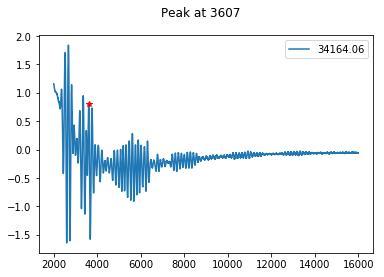

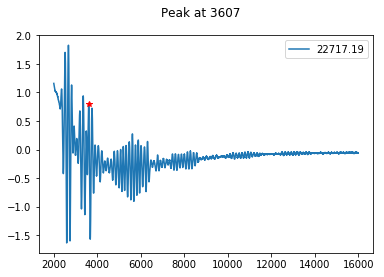

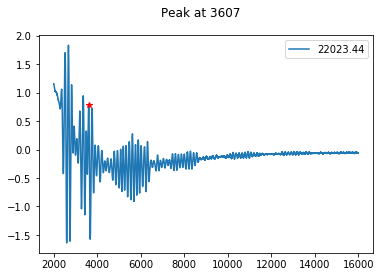

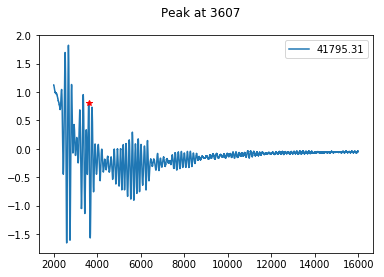

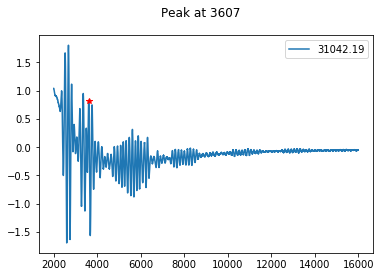

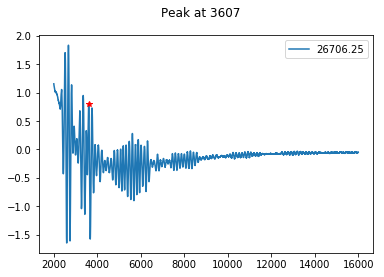

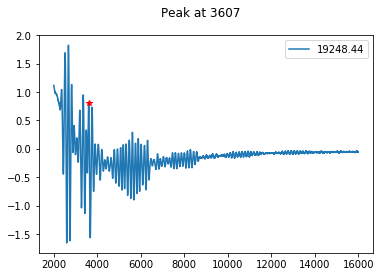

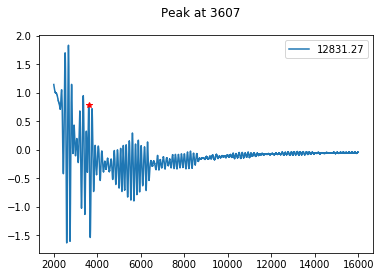

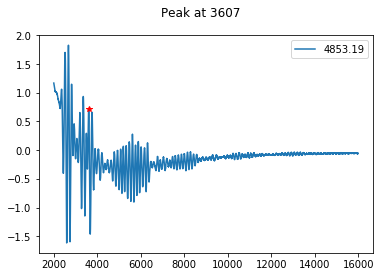

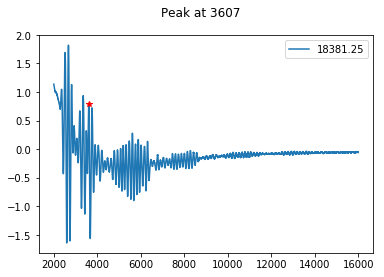

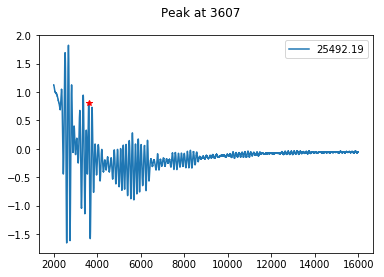

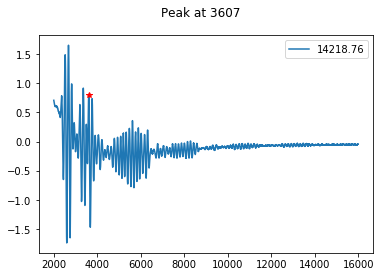

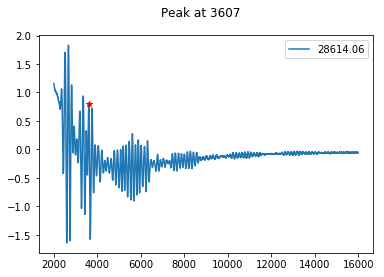

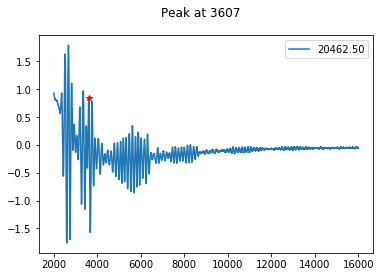

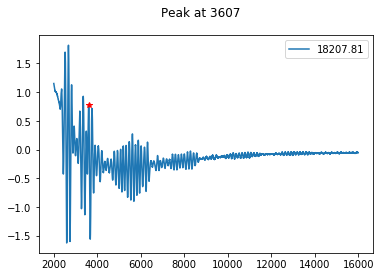

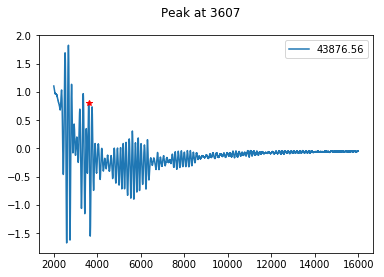

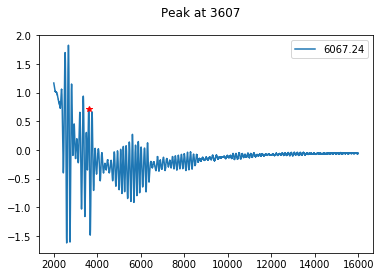

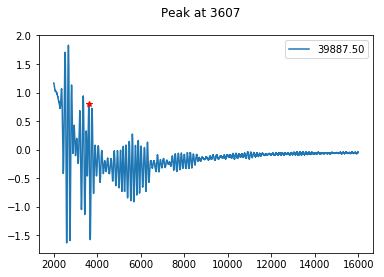

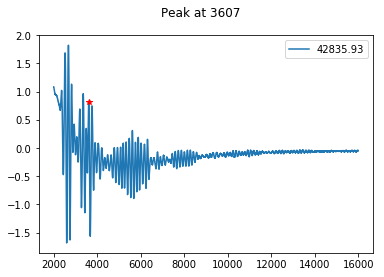

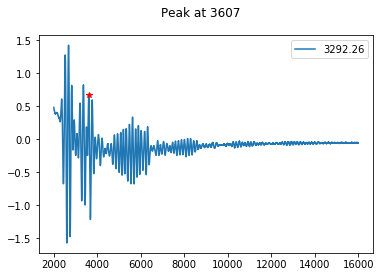

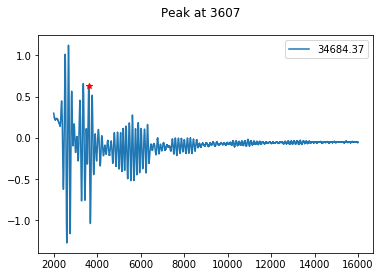

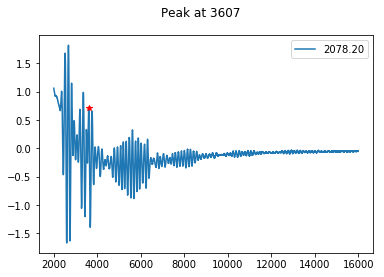

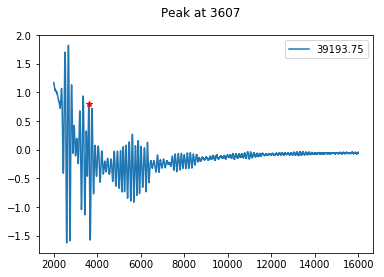

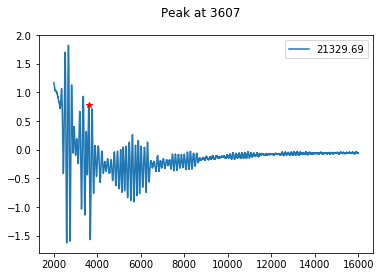

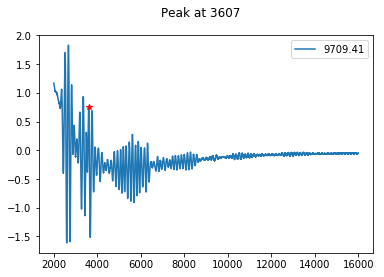

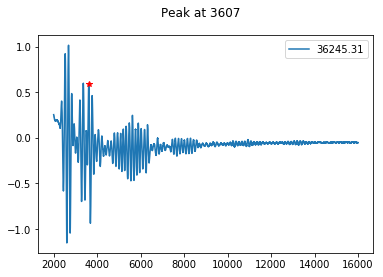

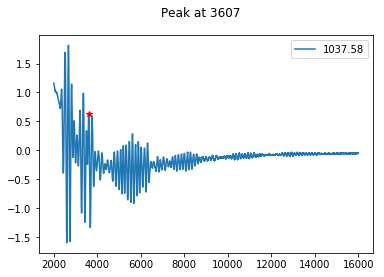

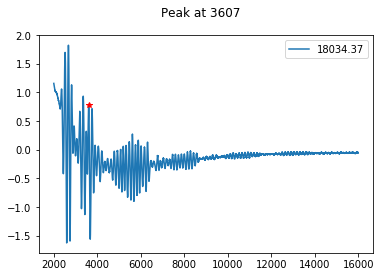

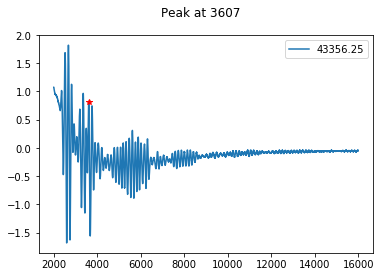

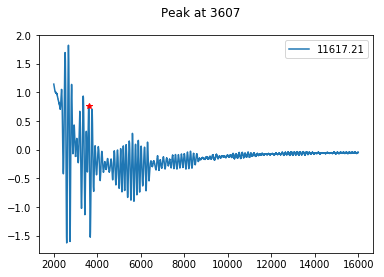

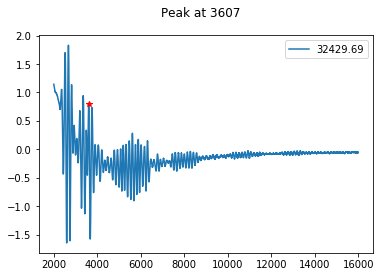

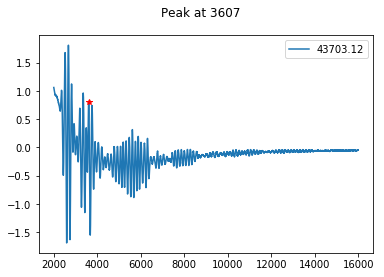

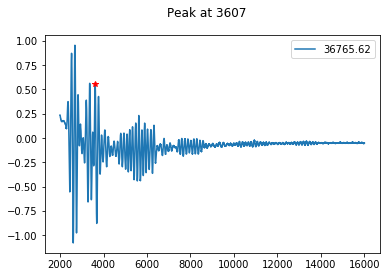

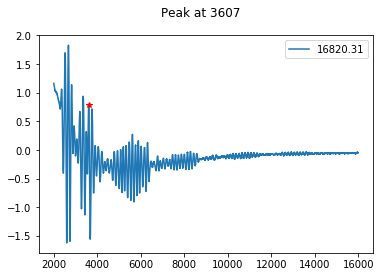

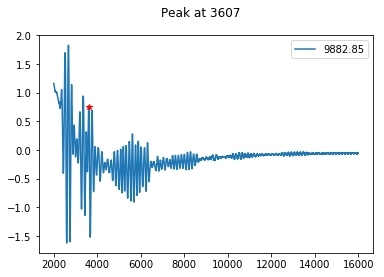

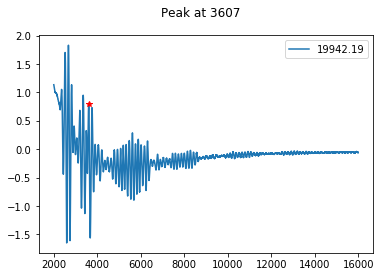

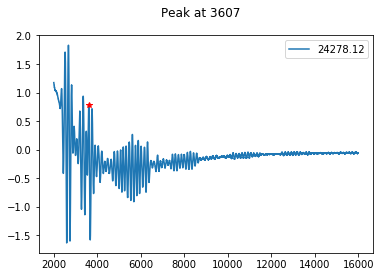

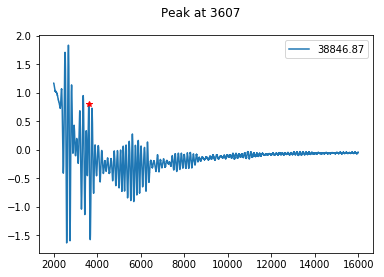

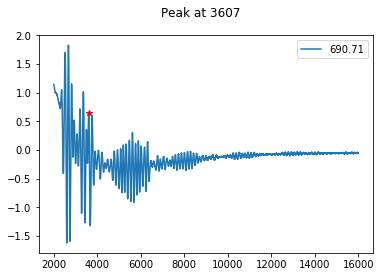

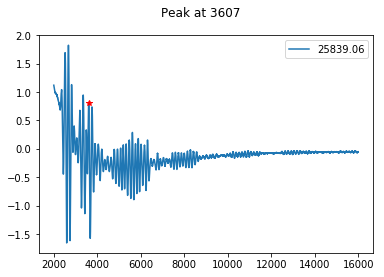

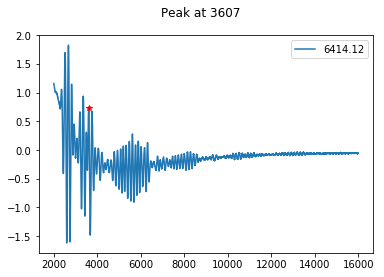

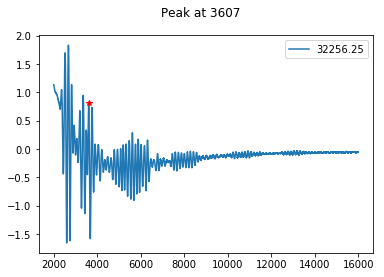

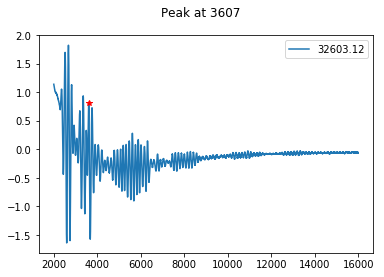

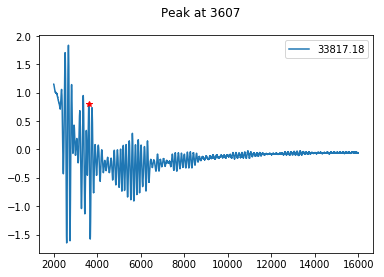

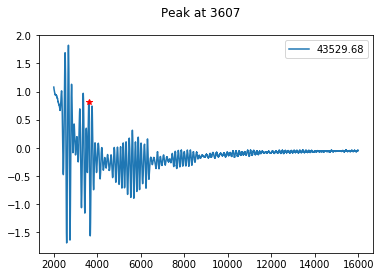

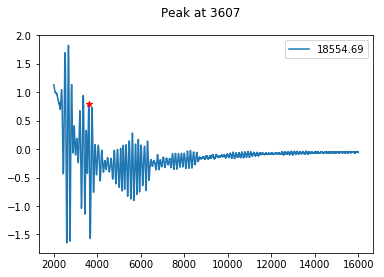

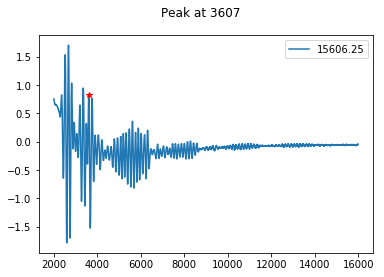

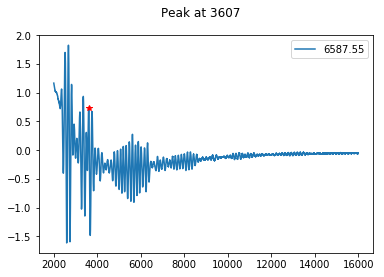

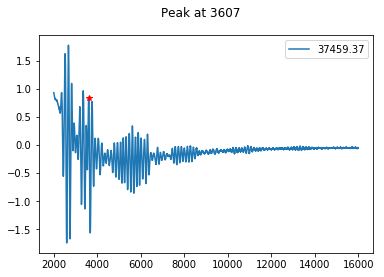

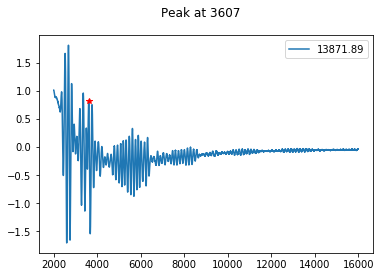

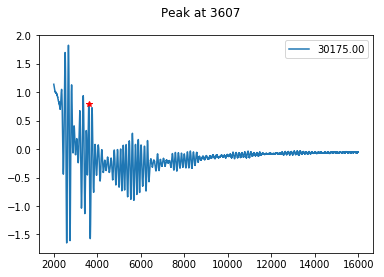

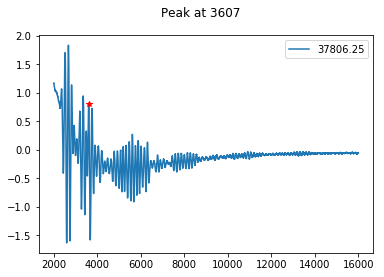

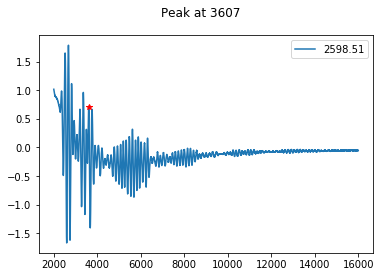

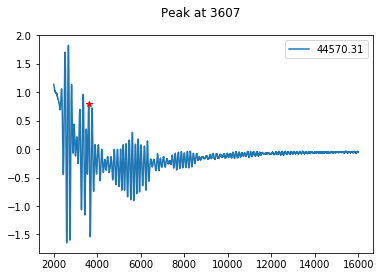

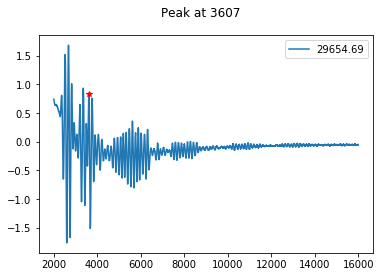

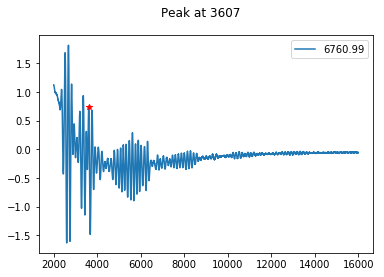

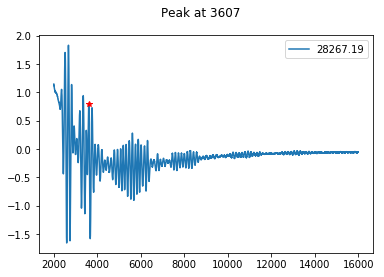

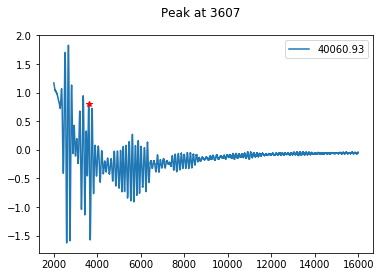

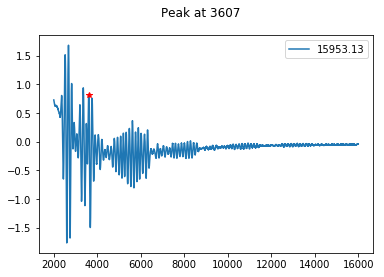

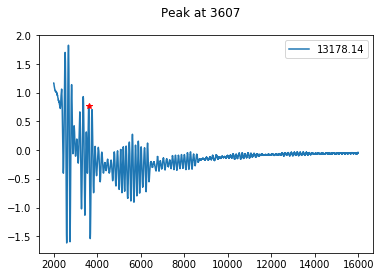

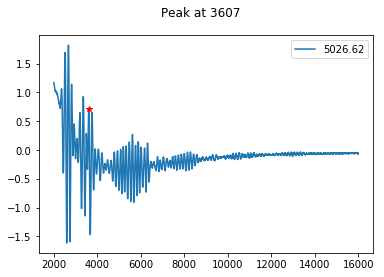

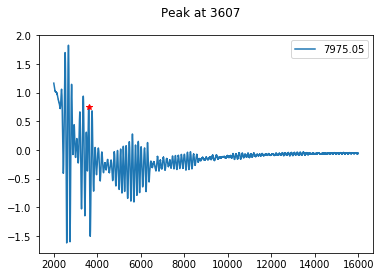

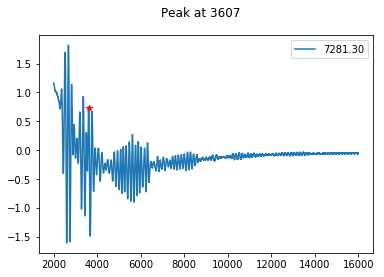

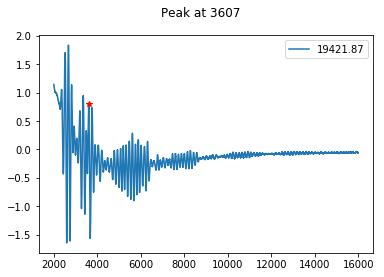

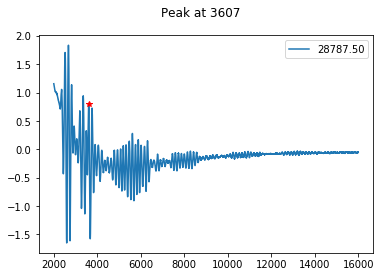

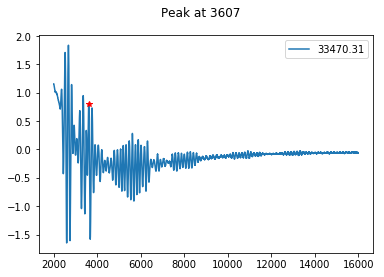

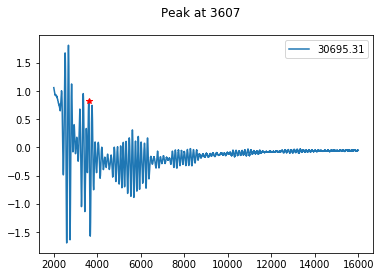

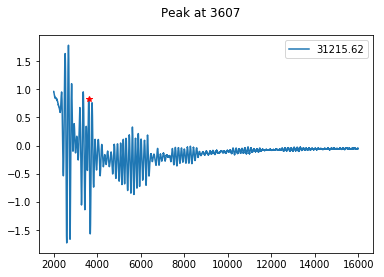

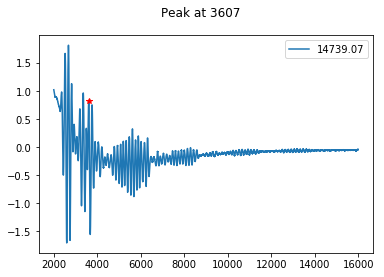

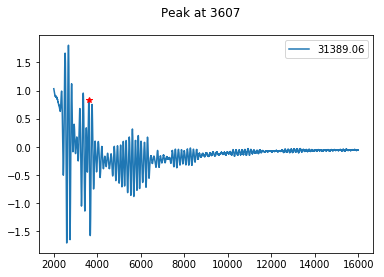

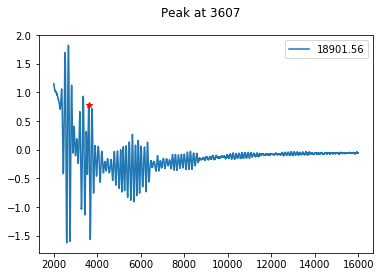

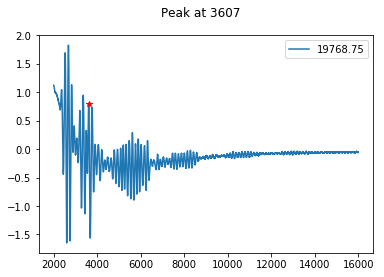

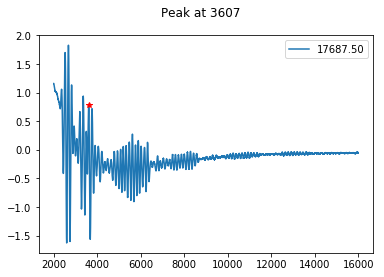

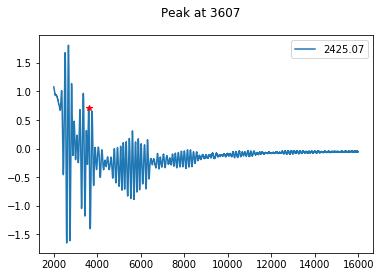

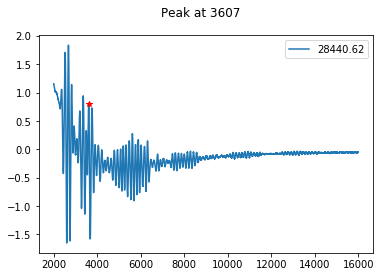

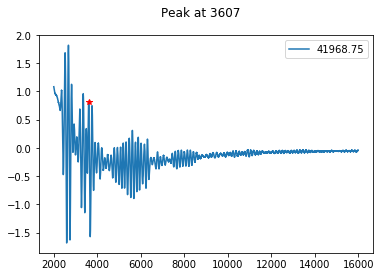

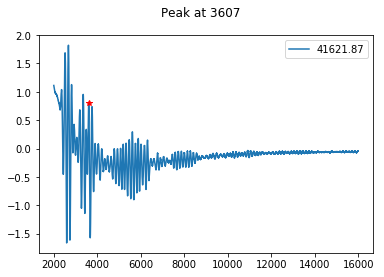

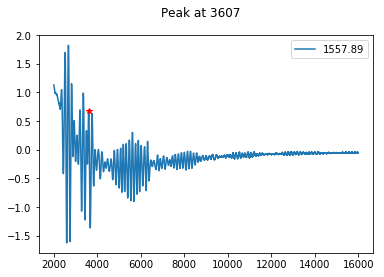

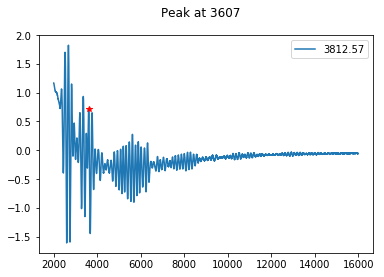

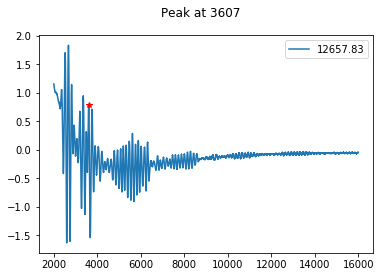

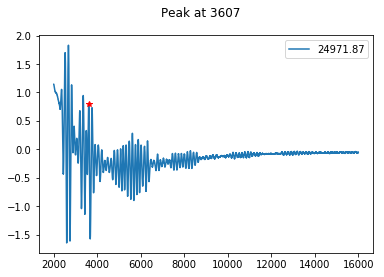

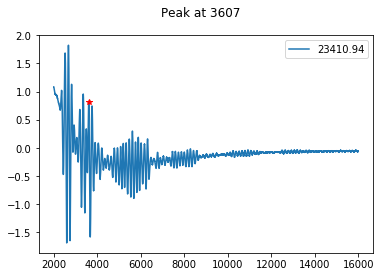

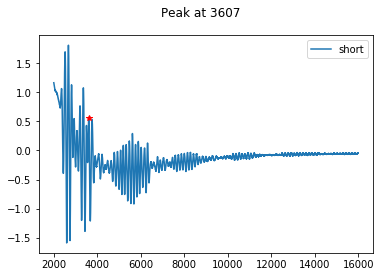

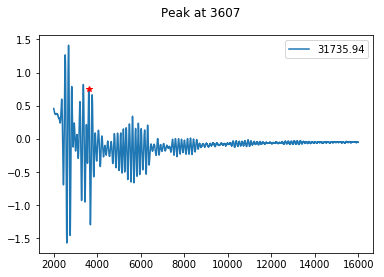

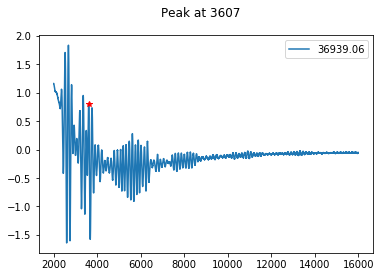

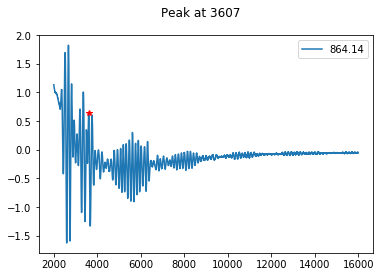

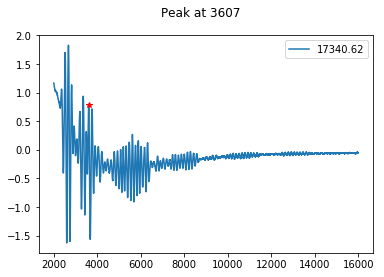

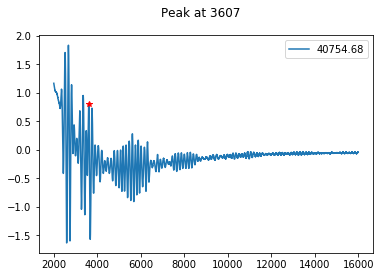

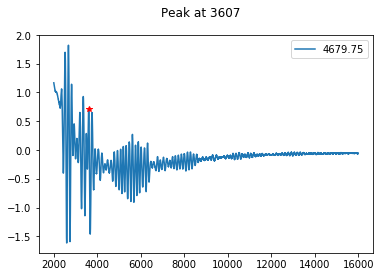

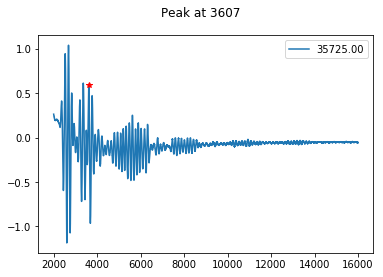

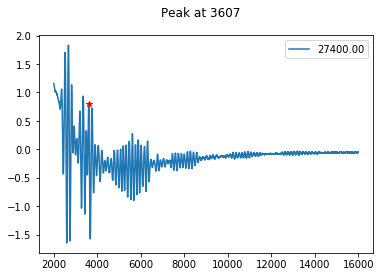

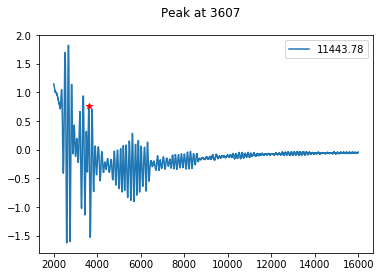

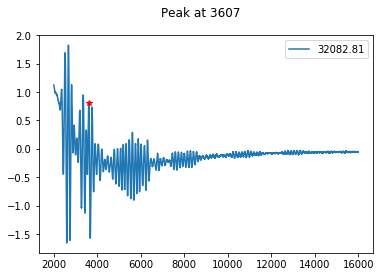

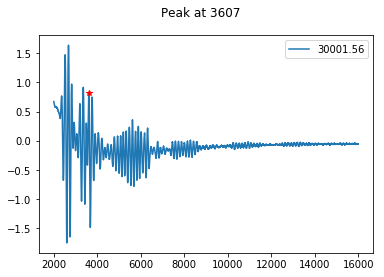

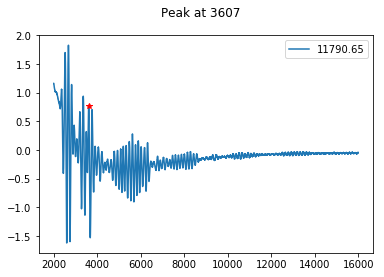

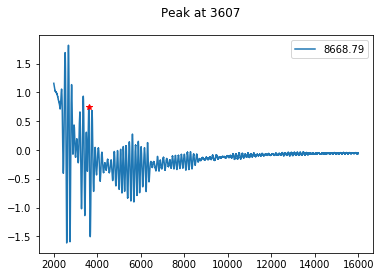

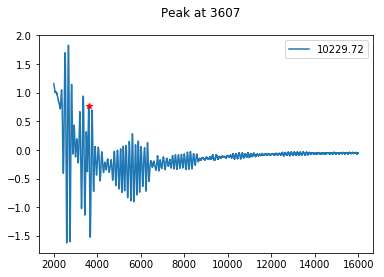

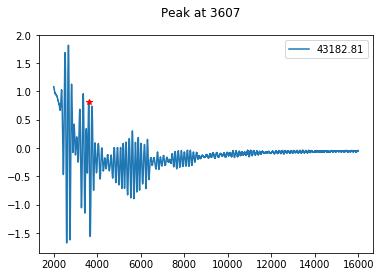

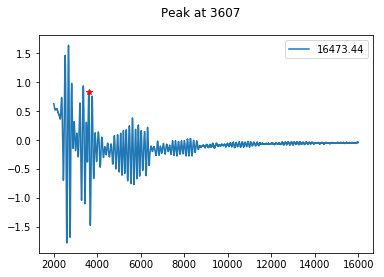

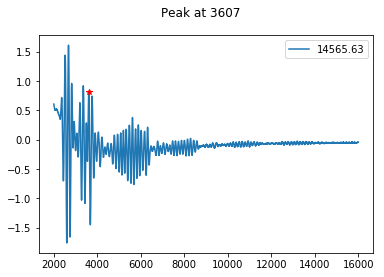

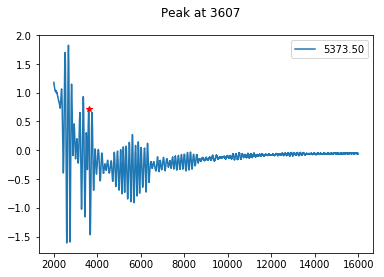

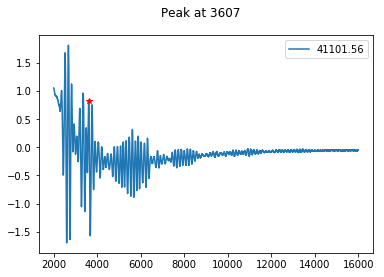

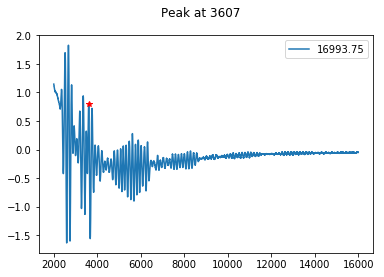

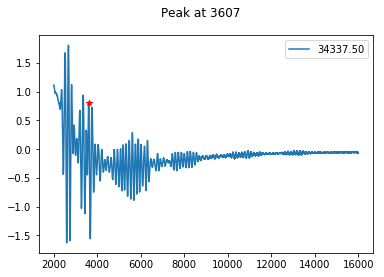

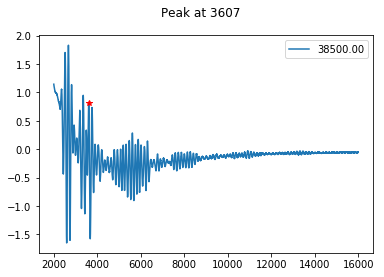

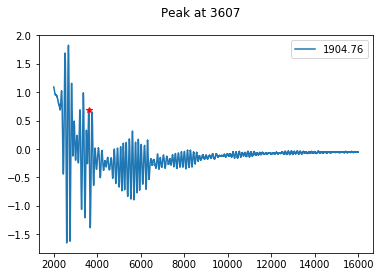

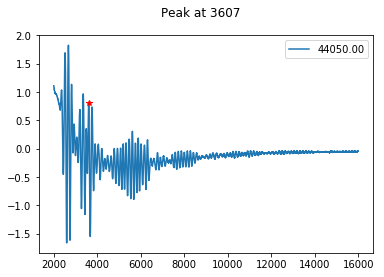

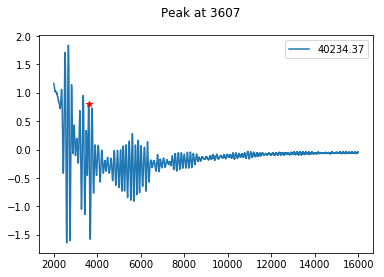

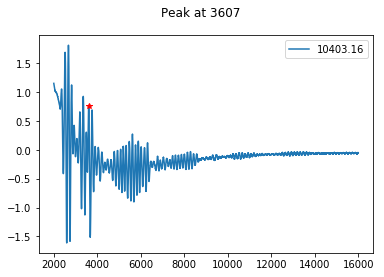

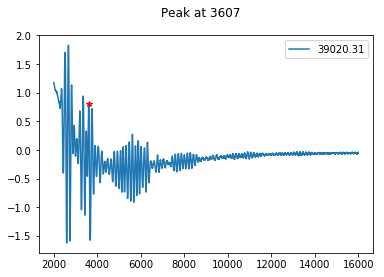

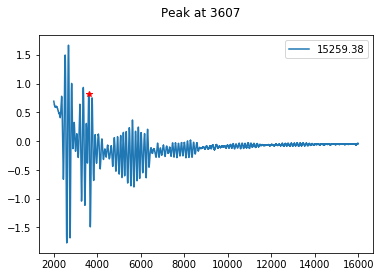

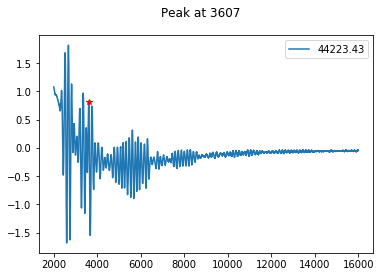

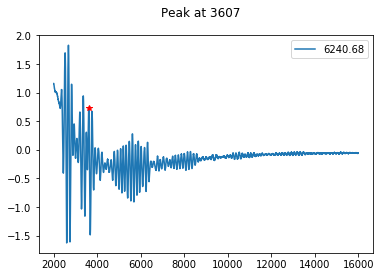

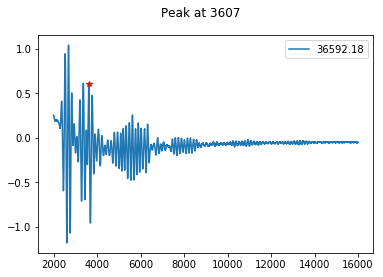

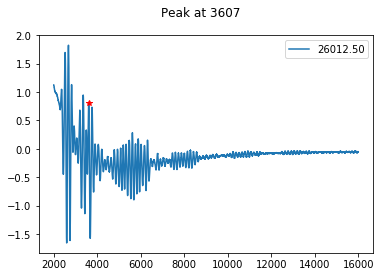

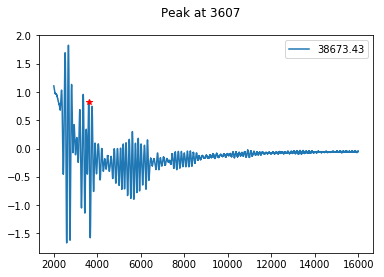

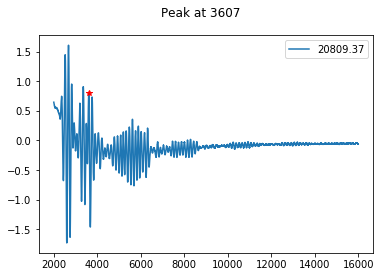

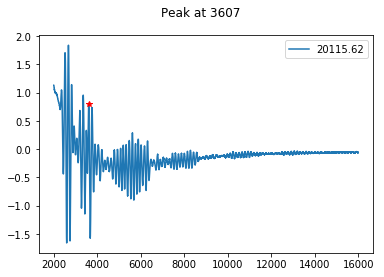

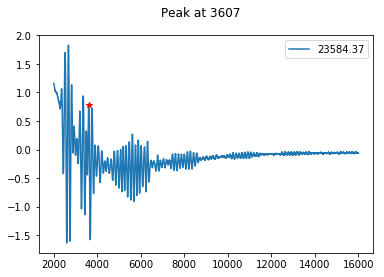

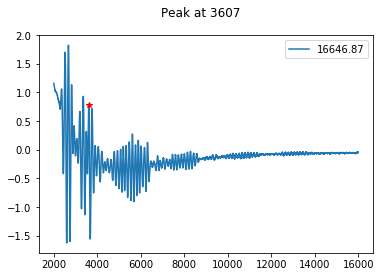

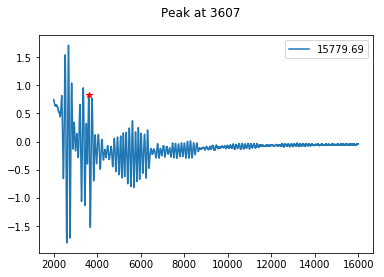

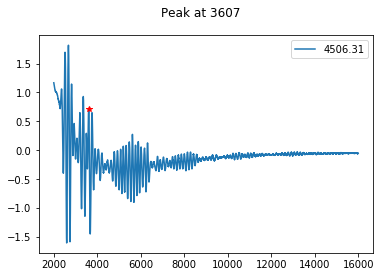

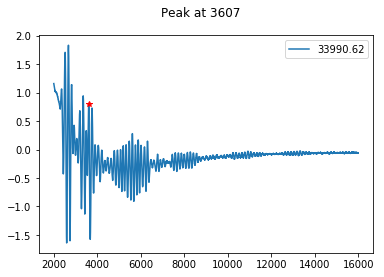

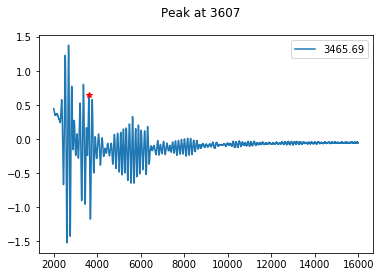

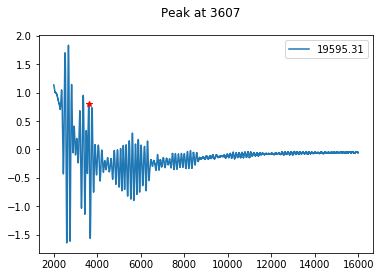

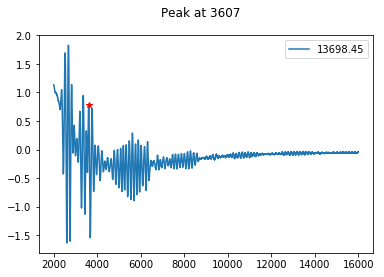

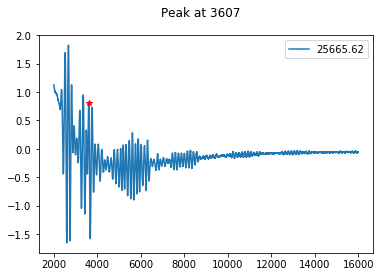

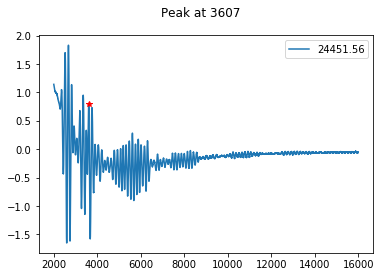

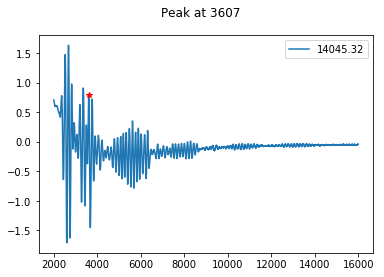

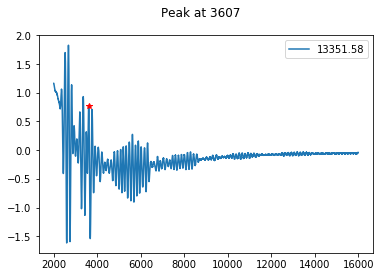

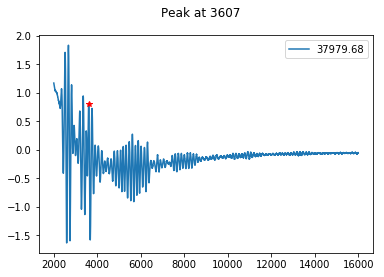

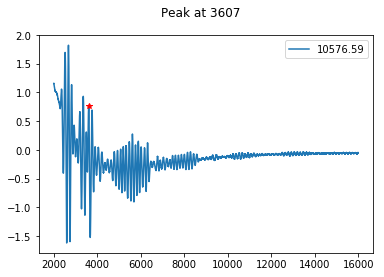

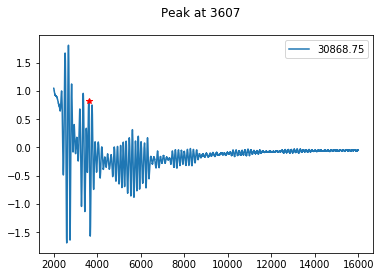

In [14]:
#Plot all the figures to ensure the correct peak was selected 
# (this is for vertification, doesn't need to be used every time)

moddict1 = pktodict(diffid)

In [22]:
#function to go from peak to plot

def plotmod(diffidx):
    print(diffidx)
    dic = pktodict(diffidx,False)
    moddf = pd.DataFrame.from_dict(dic,orient = "index")
    %matplotlib inline
    plt.ion()
    plt.figure(figsize = (8,4))
    moddf = moddf.sort_index()
    plt.title('Backscatter Modulation Voltage vs Load (pk at {})'.format(diffidx))
    plt.ylabel('Voltage (V)')
    plt.xlabel('Load ' + r'$\Omega$')
    plt.plot(moddf.index[1:],moddf.values[1:],'r*')
    plt.plot(moddf.index[1:],moddf.values[1:],'b')
    plt.axhline(moddf.loc[-1].values[0],color = 'red',label = 'open')
    error = 0.0028772277529873357 #from open condition testing
    plt.errorbar(moddf.index[1:],moddf.values[1:],error, linestyle = 'None', ecolor = 'green')
    plt.legend()
    plt.ioff()
    return moddf

3607


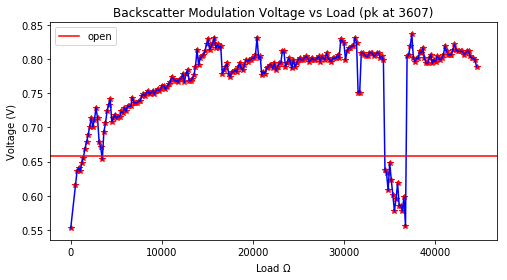

In [23]:
maxmoddf = plotmod(diffid)

***
### Peak Selection/Peak Averaging Analysis

Average over multiple peaks (not just the one with the maximum modulation)

In [24]:
#make  dataframe with peaks and their respective modulations
pkmoddf = pd.DataFrame.from_dict(dict(zip(allpks, modulation)),orient = "index")
pkmoddf.rename(columns  = {0:'modulation'},inplace = True)
pkmoddf = pkmoddf.sort_values(by = 'modulation', ascending = False)
pkmoddf.head()

modulation
3608    0.105528
3607    0.105528
3760    0.103015
5615    0.052764
5759    0.052764

In [25]:
pkmoddf.index

Int64Index([3608, 3607, 3760, 5615, 5759, 5886, 5885, 5473, 5471, 5472, 5470,
            6311, 6312, 3502, 3501, 3358, 3205, 2672, 2816, 2518, 3065, 3063,
            2932, 2931],
           dtype='int64')

In [26]:
def multipk(peaks):
    pkvalarr = np.empty((0, len(datadict.keys())))
    for pk in peaks:
        pkdic = pktodict(pk,False)
        vals = np.array(list(pktodict(pk,False).values()))
        pkvalarr = np.vstack((pkvalarr, vals))
    meanarr = np.mean(pkvalarr,axis = 0)
    meandf =  pd.DataFrame.from_dict(dict(zip([getnum(name) for name in datadict.keys()], meanarr)),orient = 'index')
    meandf = meandf.sort_index()
    plt.figure(figsize = (8,8))
    plt.title('Average Backscatter Modulation Voltage vs Load (pks at {})'.format(str(list(peaks)).strip('[]')))
    plt.ylabel('Voltage (V)')
    plt.xlabel('Load ' + r'$\Omega$')
    plt.plot(meandf.index[1:],meandf.values[1:],'r*')
    plt.plot(meandf.index[1:],meandf.values[1:],'b', label = 'Peak modulation')
    plt.axhline(meandf.loc[-1].values[0],color = 'red',label = 'open')
    error = 0.0028772277529873357 #from open condition testing
    plt.errorbar(meandf.index[1:],meandf.values[1:],error, linestyle = 'None', ecolor = 'green')
    plt.legend()
    return meandf

In [27]:
selectedpks = pkmoddf.index

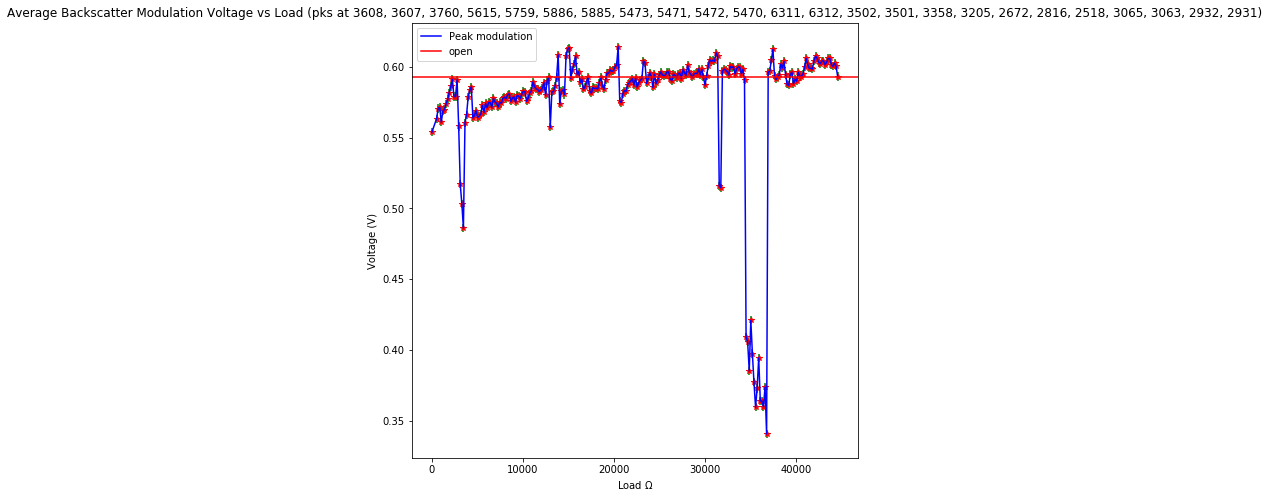

In [28]:
selpkdf = multipk(selectedpks)

2518


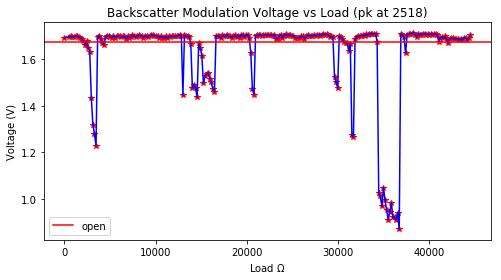

2672


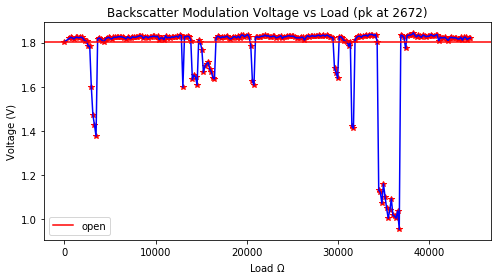

2816


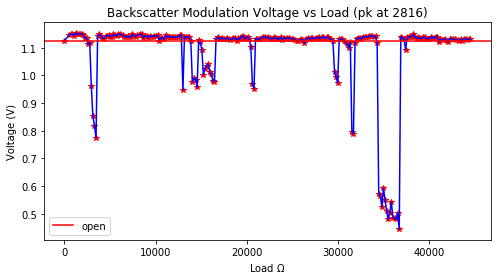

2931


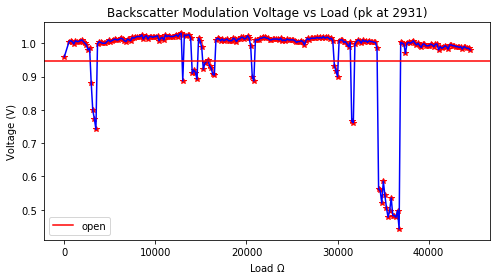

2932


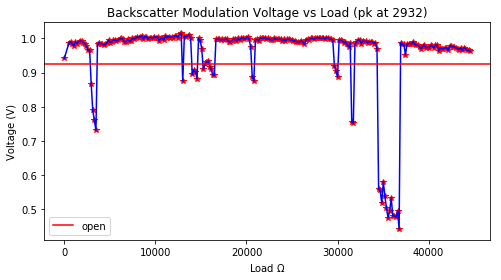

3063


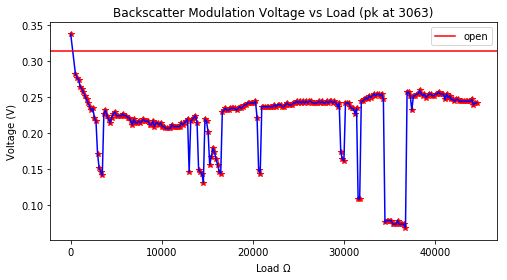

3065


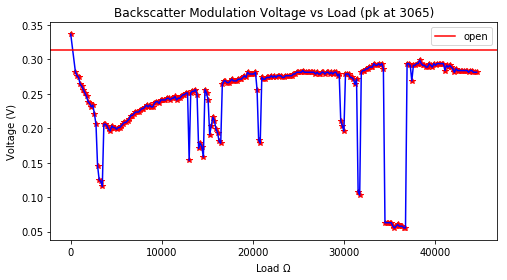

3205


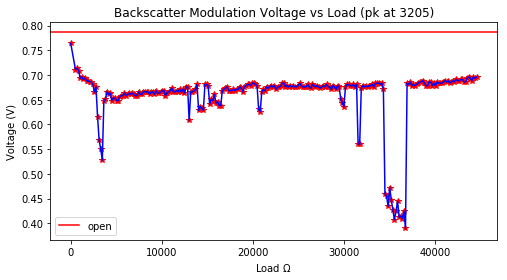

3358


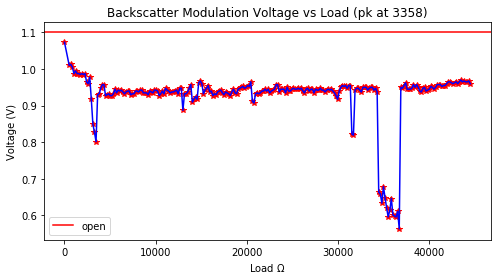

3501


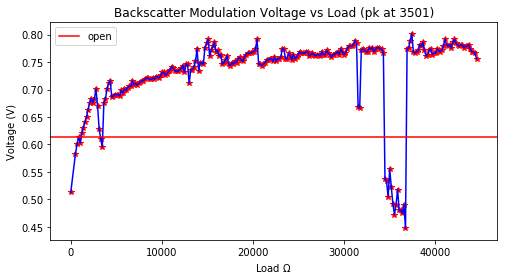

3502


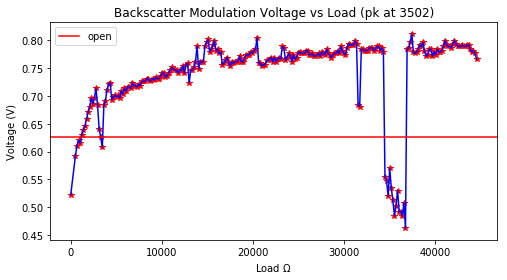

3607


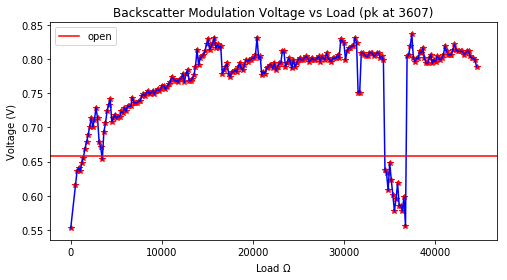

3608


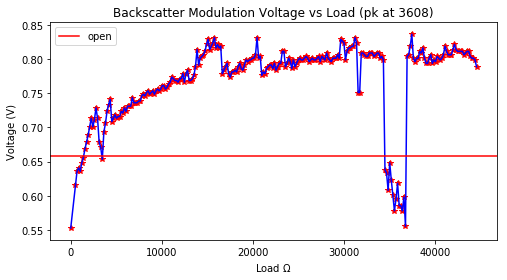

3760


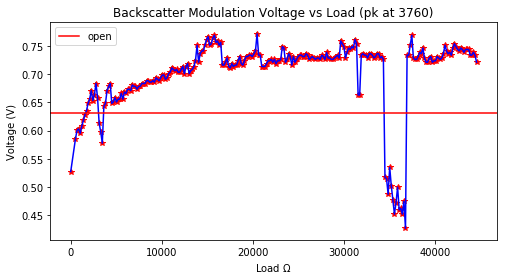

5470


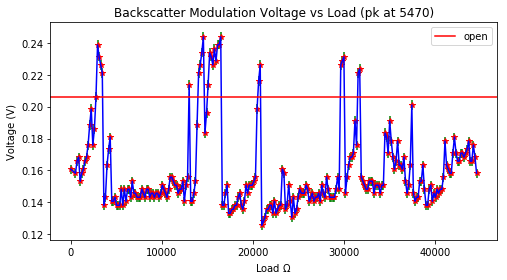

5472


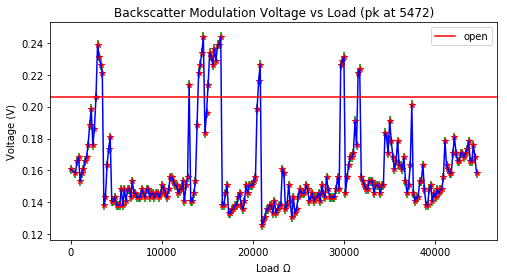

5471


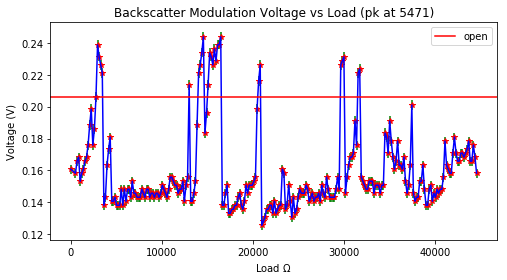

5473


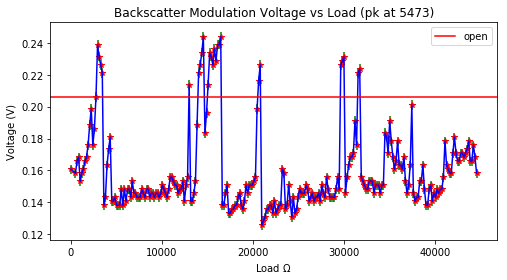

5615


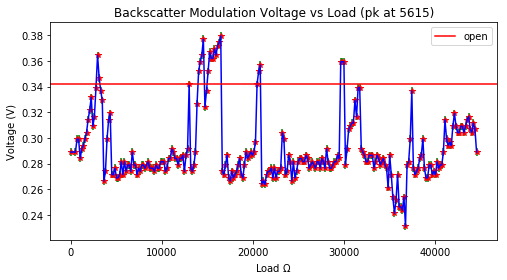

5759


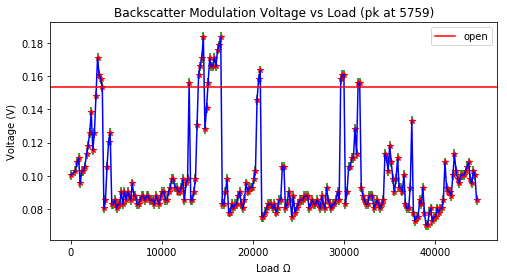

5885


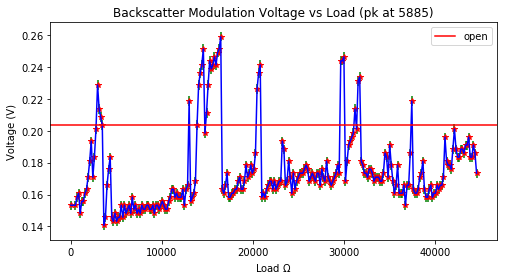

5886


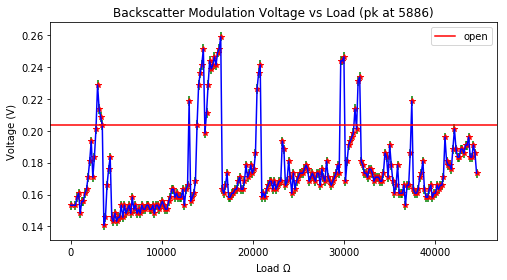

6311


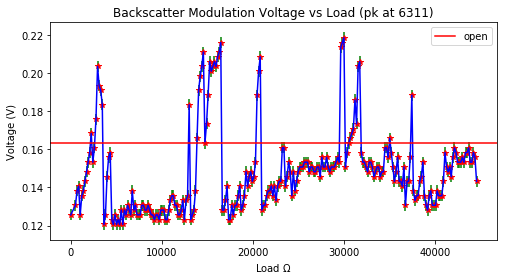

6312


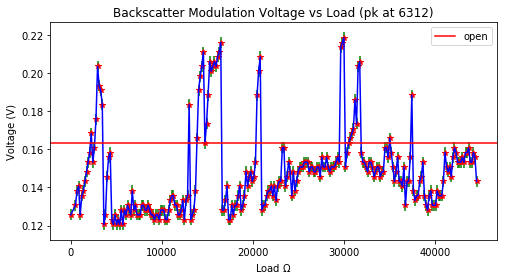

In [29]:
for pk in allpks:
    plt.figure()
    plotmod(pk)
    plt.show()

In [30]:
np.mean(selpkdf.values)

0.5764132829136186